# shipmmg v0.0.10

- [shipmmg](https://github.com/ShipMMG/shipmmg) is a unofficial Python package of ship maneuvering simulation with respect to the research committee on “standardization of mathematical model for ship maneuvering predictions” was organized by the JASNAOE.

- Now, we can install shipmmg from [PyPI](https://pypi.org/project/shipmmg/), [anaconda](https://anaconda.org/taiga4112/shipmmg) or [GitHub](https://github.com/ShipMMG/shipmmg)

In [1]:
import shipmmg
from shipmmg.kt import KTParams, simulate_kt
# from shipmmg.mmg_3dof import (
from shipmmg.mmg_3dof_EX import ( #外乱影響を出す場合
    Mmg3DofBasicParams,
    Mmg3DofManeuveringParams,
    simulate_mmg_3dof,
    zigzag_test_mmg_3dof,
    get_sub_values_from_simulation_result,
)
from shipmmg.ship_obj_3dof import ShipObj3dof
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee']) # ここでスタイルを設定する

In [2]:
print(shipmmg.__version__)

0.0.10


---
# MMG 3DOF simulation DEMO using suzaku model

## 1. Simulation setting

In [3]:
#Suzaku-model
ρ = 1025.0  # 海水密度

nabla = 0.2358  # 排水量[m3] Lpp*B*d*Cb 0.231?
L_pp = 3.50  # 船長Lpp[m]
B = 0.57  # 船幅[m]
d = 0.16  # 喫水[m]
x_G = 0.0112  # 重心位置[]
C_b = 0.7390 # 方形係数 0.72368?
D_p = 0.03373 * L_pp #0.120  # プロペラ直径[m]
m = 1025 * nabla  # 質量(無次元化)[kg]
# I_zG = 1025 * nabla * ((0.25 * L_pp)^2)  # 慣性モーメント[-]  kg/m3 * m3 *m2
A_R = 0.0189  # 船の断面に対する舵面積比[-]
η = 0.8023  # プロペラ直径に対する舵高さ(Dp/H)
m_x_dash = 0.0475 # 付加質量x(無次元) kg/m3 * m2 * m /kg
m_y_dash = 0.6739 # 付加質量y(無次元)
J_z_dash = 0.0306 # 付加質量Izz(無次元)
f_α = 2.634 # 直圧力勾配係数
ϵ = 1.345  # プロペラ・舵位置伴流係数比
t_R = 0.084  # 操縦抵抗減少率 
a_H = 0.054  # 舵力増加係数
x_H = -0.388 * L_pp  # 舵力増分作用位置
γ_R_minus = 0.225 # 整流係数
γ_R_plus = 0.574  # 整流係数
l_R = -0.641  # 船長に対する舵位置
κ = 0.482  # 修正係数
t_P = 0.035  # 推力減少率 #モデルの違い
w_P0 = 0.397  # 有効伴流率 #モデルの違い
# t_P = 0.180  # 推力減少率 #モデルの違い
# w_P0 = 0.40  # 有効伴流率 #モデルの違い
x_P = -0.490  # 船長に対するプロペラ位置 #モデルの違い
x_R = -0.500 * L_pp
# m_x= m_x_dash  # 付加質量x(無次元)
# m_y= m_y_dash  # 付加質量y(無次元)
# J_z= J_z_dash  # 付加質量Izz(無次元)
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash  # 付加質量x(無次元)
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash  # 付加質量y(無次元)
J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash  # 付加質量Izz(無次元)

basic_params = Mmg3DofBasicParams(
    L_pp=L_pp,  # 船長Lpp[m]
    B=B,  # 船幅[m]
    d=d,  # 喫水[m]
    x_G=x_G,  # 重心位置[]
    D_p=D_p,  # プロペラ直径[m]
    m=ρ * nabla,  # 質量(無次元化)[kg]
    I_zG=ρ * nabla * ((0.25 * L_pp) ** 2),  # 慣性モーメント
    A_R=A_R,  # 船の断面に対する舵面積比
    η=η,  # プロペラ直径に対する舵高さ(Dp/H)
    m_x=m_x,  # 付加質量x(無次元)
    m_y=m_y,  # 付加質量y(無次元)
    J_z=J_z,  # 付加質量Izz(無次元)
    f_α=f_α,
    ϵ=ϵ,  # プロペラ・舵位置伴流係数比
    t_R=t_R,  # 操縦抵抗減少率
    x_R=-0.500 * L_pp,  # 舵の相対位置
    a_H=a_H,  # 舵力増加係数
    x_H=-0.388 * L_pp,  # 舵力増分作用位置
    γ_R_minus=γ_R_minus,  # 整流係数
    γ_R_plus=γ_R_plus,  # 整流係数
    l_R=l_R,  # 船長に対する舵位置
    x_P=x_P,  # 船長に対するプロペラ位置
    κ=κ,  # 修正係数
    t_P=t_P,  # 推力減少率
    w_P0=w_P0,  # 有効伴流率
)

k_0 = 0.3516
k_1 = -0.3624
k_2 = -0.1100
R_0_dash = 0.020
X_vv_dash = -0.07993
X_vr_dash = 0.10163
X_rr_dash = -0.01487
X_vvvv_dash = 0.57037
Y_v_dash = -0.37112
Y_r_dash = 0.07203
# Y_v_dash = -0.3384 #-0.37112
# Y_r_dash = 0.1976 #0.07203
Y_vvv_dash = -1.05345
Y_vvr_dash = 0.20726
Y_vrr_dash = -0.25560
Y_rrr_dash = 0.02196
N_v_dash = -0.10969
N_r_dash = -0.04994
# N_v_dash = -0.1377 #-0.10969
# N_r_dash = -0.0992#-0.04994
N_vvv_dash = -0.05329
N_vvr_dash = -0.28770
N_vrr_dash = -0.02059
N_rrr_dash = -0.01959

maneuvering_params = Mmg3DofManeuveringParams(
    k_0=k_0,
    k_1=k_1,
    k_2=k_2,
    R_0_dash=R_0_dash,
    X_vv_dash=X_vv_dash,
    X_vr_dash=X_vr_dash,
    X_rr_dash=X_rr_dash,
    X_vvvv_dash=X_vvvv_dash,
    Y_v_dash=Y_v_dash,
    Y_r_dash=Y_r_dash,
    Y_vvv_dash=Y_vvv_dash,
    Y_vvr_dash=Y_vvr_dash,
    Y_vrr_dash=Y_vrr_dash,
    Y_rrr_dash=Y_rrr_dash,
    N_v_dash=N_v_dash,
    N_r_dash=N_r_dash,
    N_vvv_dash=N_vvv_dash,
    N_vvr_dash=N_vvr_dash,
    N_vrr_dash=N_vrr_dash,
    N_rrr_dash=N_rrr_dash,
)

In [4]:
duration = 200  # [s]
# steering_rate = 1.76 * 4  # [°/s]
max_δ_rad = 20 * np.pi / 180.0  # [rad]
n_const = 9  # [rps]
# n_const = 17.95  # [rps]
sampling_hz = 1  # [Hz]
sampling = duration * sampling_hz
time_list = np.linspace(0.00, duration, sampling)
δ_rad_list = [0] * sampling
for i in range(sampling):
    δ_rad_list[i] = max_δ_rad

npm_list = np.array([n_const for i in range(sampling)])

Average Wave Period (peak-to-peak): 1.83 s


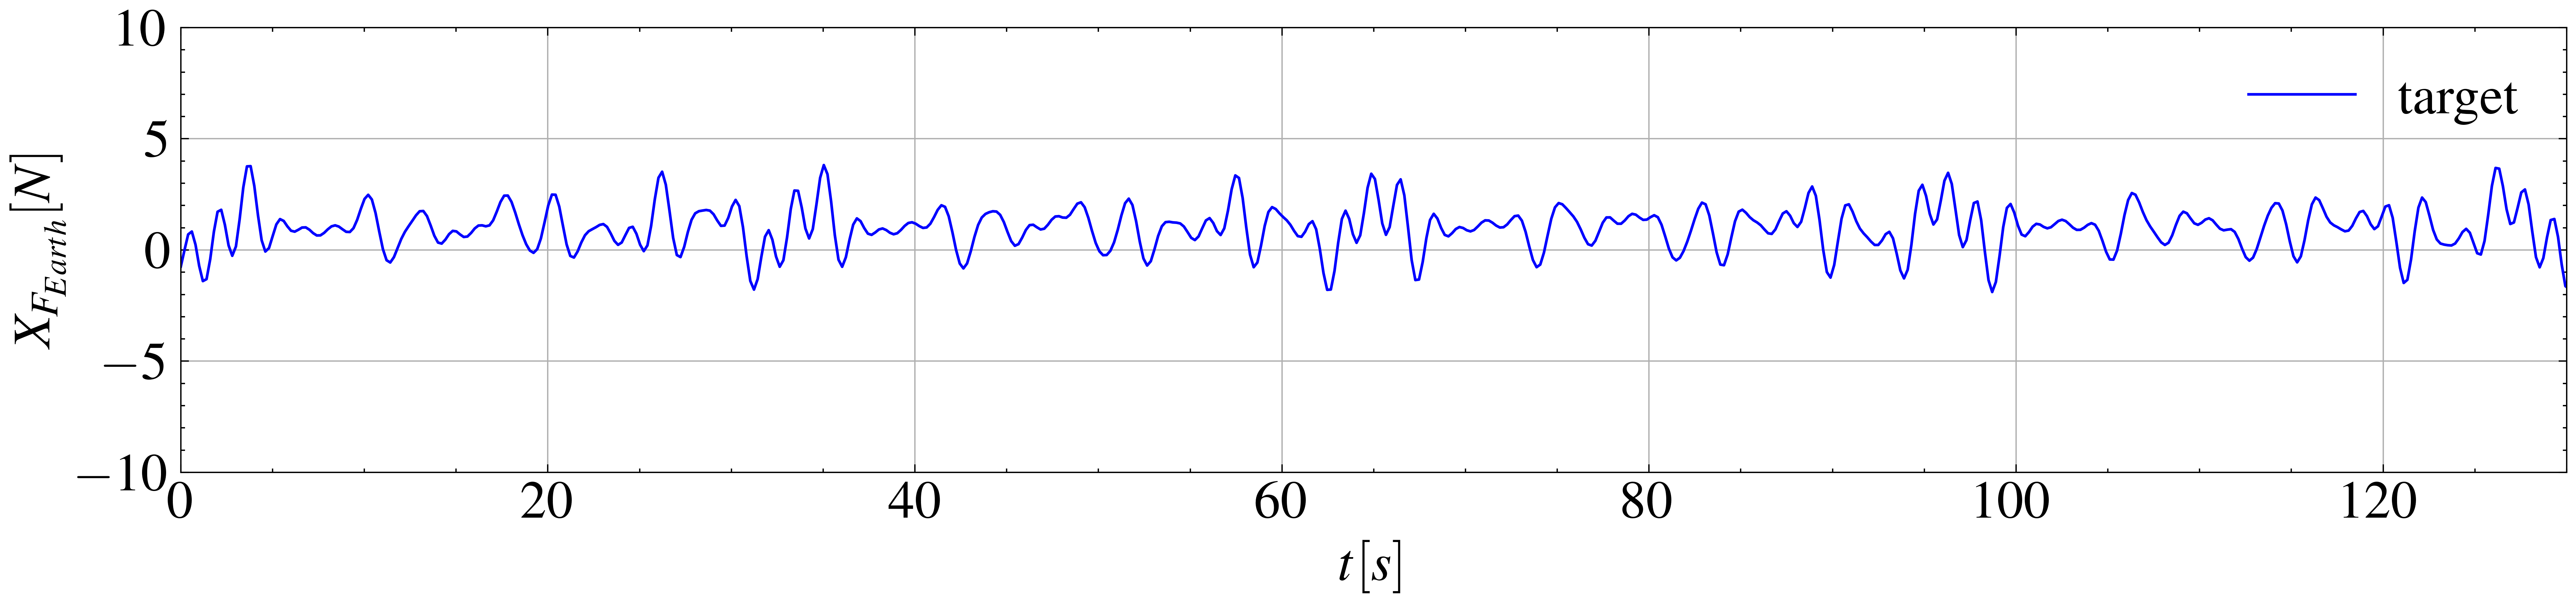

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# パラメータ設定
num_waves = 20  # 重ね合わせる波の数
amplitude = 0.3  # 波の振幅
frequency = np.linspace(0.1, 0.7, num_waves)  # 波の周波数を低く設定
np.random.seed(0)
phase = np.random.rand(num_waves) * 2 * np.pi  # ランダムな位相

# 時間の設定
time = np.linspace(0, 200, 1000)

# 不規則波の生成
wave = np.zeros_like(time)
for i in range(num_waves):
    wave += amplitude * np.sin(2 * np.pi * frequency[i] * time + phase[i]) + 1/20

# ピークを検出
peaks, _ = find_peaks(wave)

# ピーク間の時間間隔を計算
peak_times = time[peaks]
periods = np.diff(peak_times)
average_period = np.mean(periods)

# 結果の表示
print(f"Average Wave Period (peak-to-peak): {average_period:.2f} s")

# 波のプロット
fig = plt.figure(figsize=(16, 3))
plt.plot(time, wave, c='b', label='target')
# plt.plot(peak_times, wave[peaks], "x", label='Peaks')
plt.xlabel("$t [s]$", fontsize=20)
plt.ylabel("$X_{F_{Earth}}[N]$", fontsize=20)
plt.xlim(0,130)
plt.ylim(-10,10)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20, loc='upper right')
plt.grid()
plt.show()

## 2. Simulation

In [6]:
sol = simulate_mmg_3dof(
    basic_params,
    maneuvering_params,
    time_list,
    δ_rad_list,
    npm_list,
    # u0=0.656,
    # u0=1.0,
    u0=2.0,
    # u0=0.6,
    v0=0.0,
    r0=0.0,
)
result = sol.sol(time_list)

/Users/harukiyamamoto/.pyenv/versions/3.11.4/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `s0`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


## 3. Visualizing by using utility class `ShipObj3dof`

### 3-1. Load simulation result

In [7]:
ship = ShipObj3dof(L=basic_params.L_pp, B=basic_params.B)
# ship.load_simulation_result(time_list, result[0], result[1], result[2]) # v0.0.9
ship.register_simulation_result(time_list, result[0], result[1], result[2], result[3], result[4], result[5])

In [8]:
len(time_list)

200

### 3-2. Draw simulation result

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


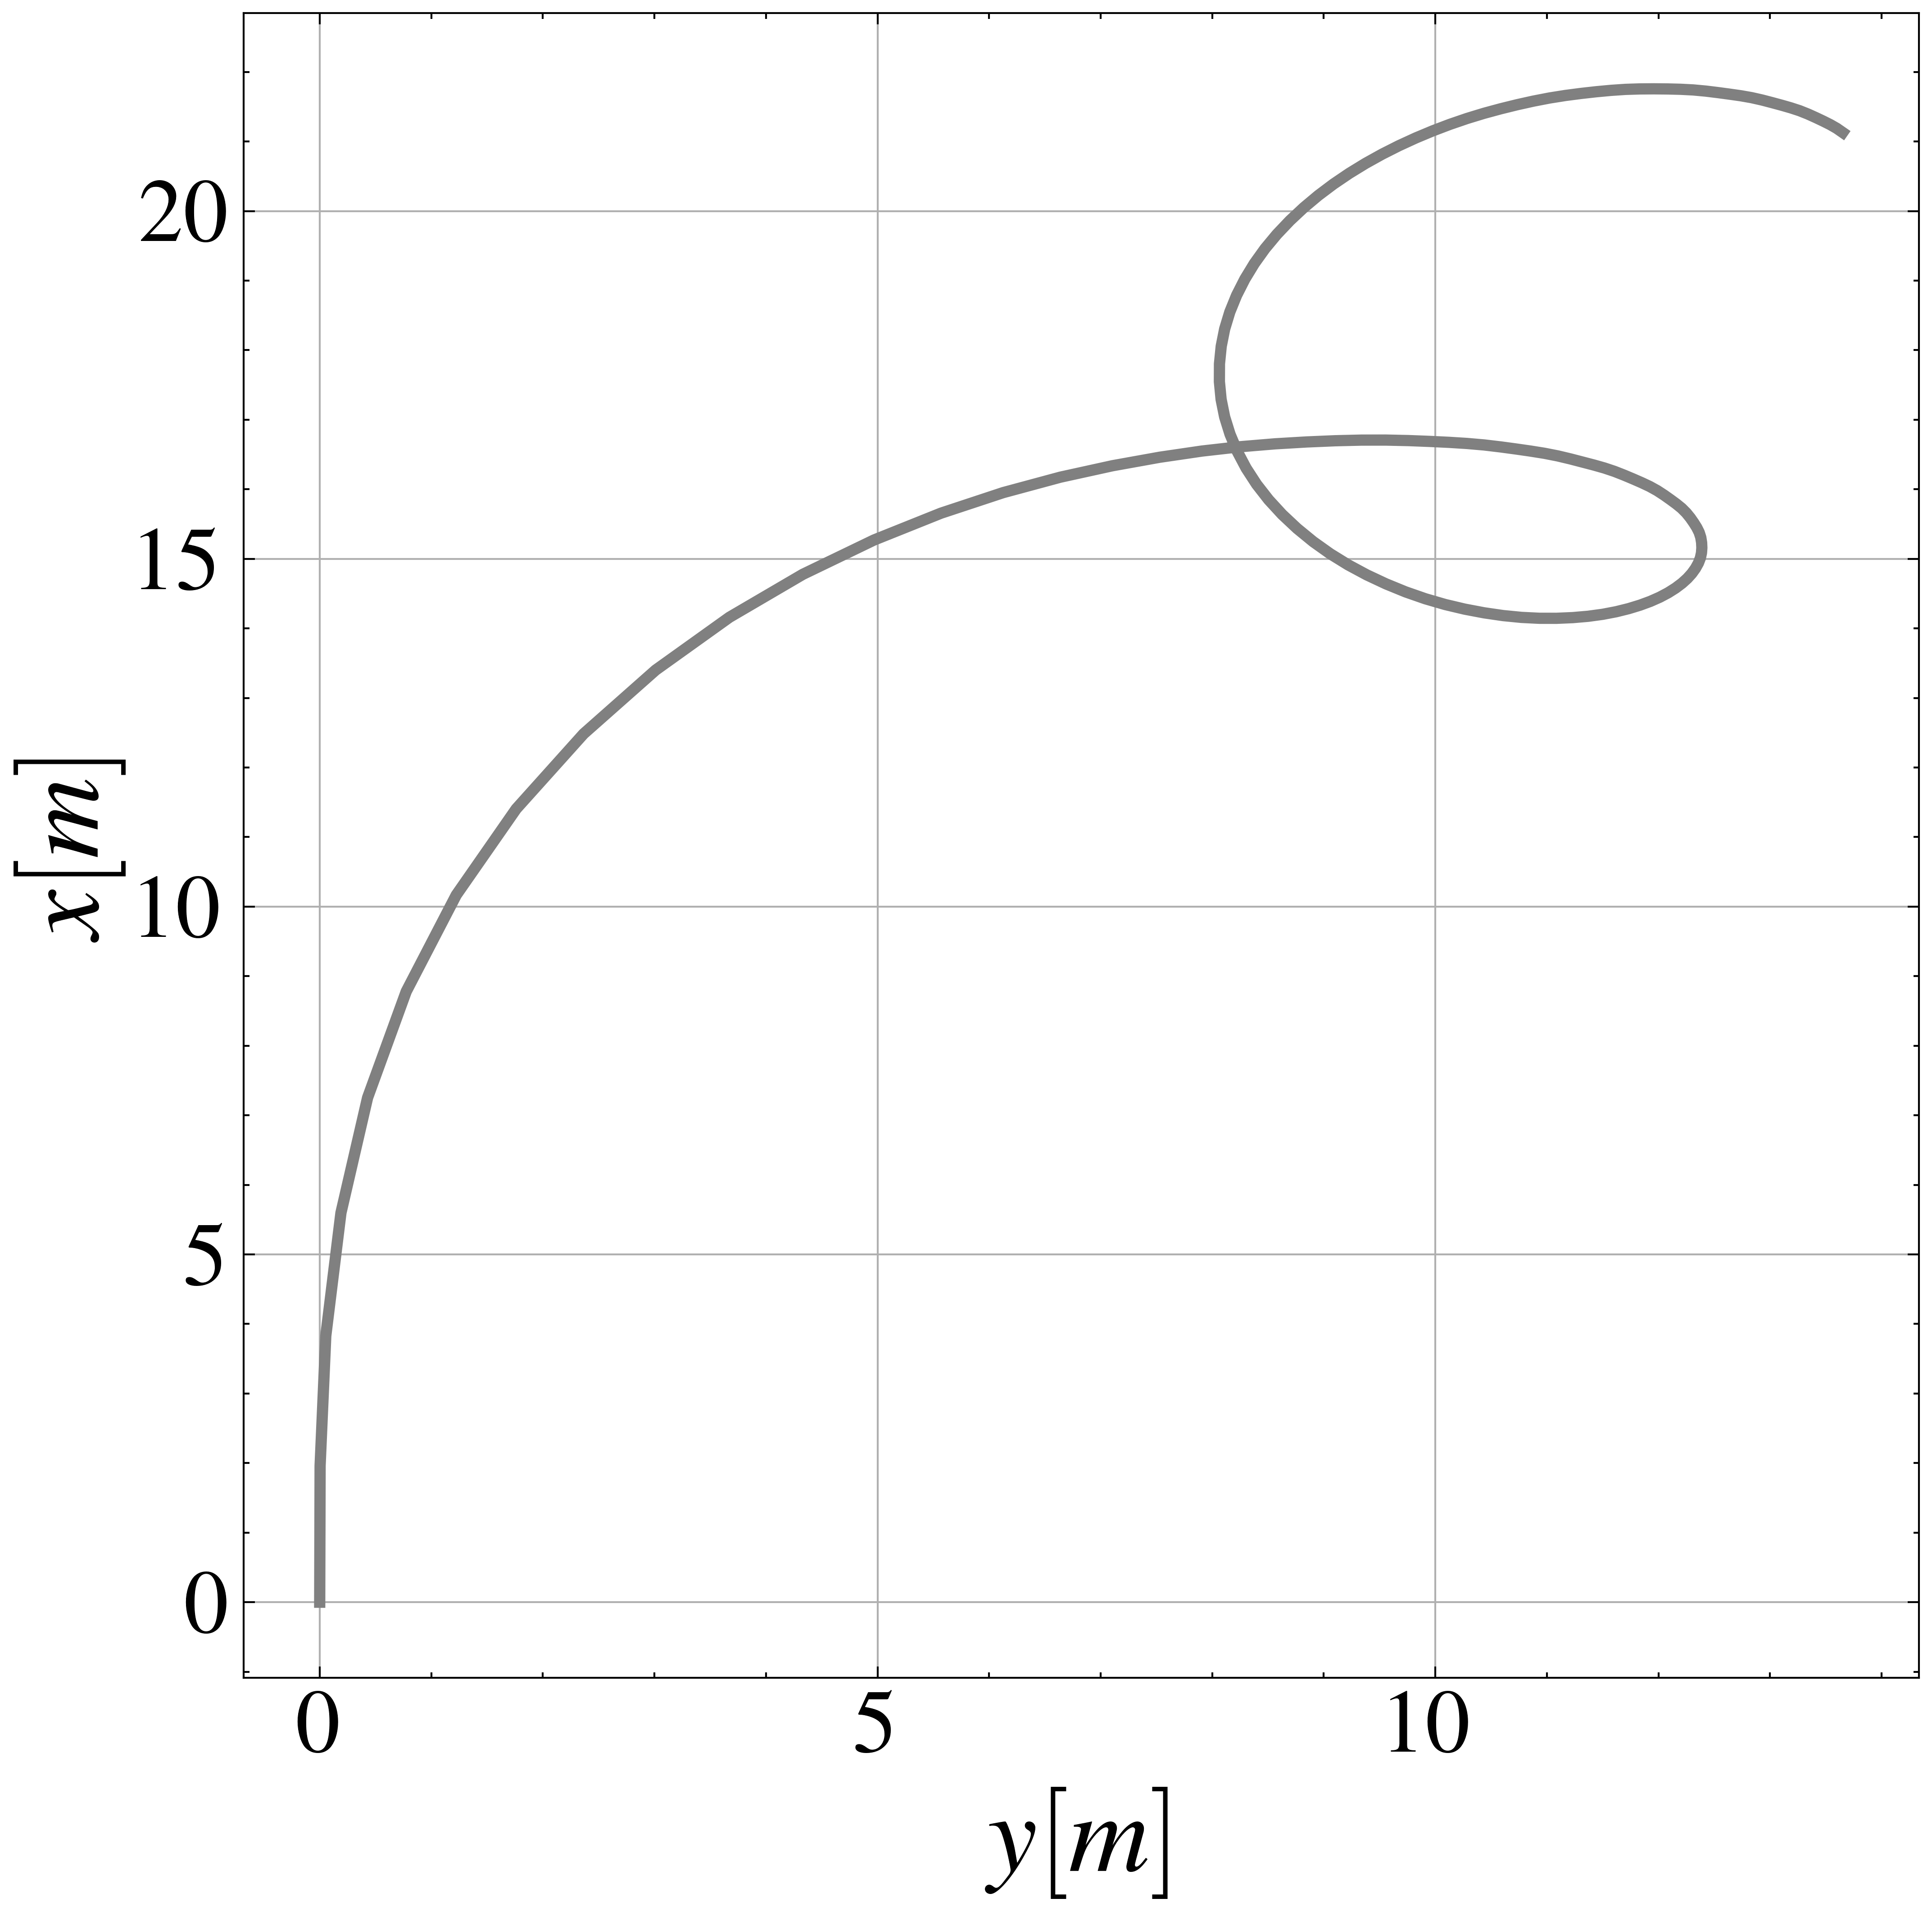

In [9]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8.0,8.0))
# plt.plot(result[4], result[3], c='b', label='EF')
plt.plot(result[4][0:150*sampling_hz], result[3][0:150*sampling_hz], c='gray', linestyle='-', linewidth=3)
# plt.plot(result[4][38*sampling_hz:42*sampling_hz], result[3][38*sampling_hz:42*sampling_hz], c='r', marker='o')
# plt.plot(result[4][13*sampling_hz:17*sampling_hz], result[3][13*sampling_hz:17*sampling_hz], c='r', marker='o')
# plt.plot(df['y'], df['x'], c='r', label='mpc')
plt.xlabel('$y[m]$', fontsize=30)
plt.ylabel('$x[m]$', fontsize=30)
plt.tick_params(labelsize=24)
plt.grid()
plt.legend(fontsize=24)

In [10]:
(
    X_H_list,
    X_R_list,
    X_P_list,
    Y_H_list,
    Y_R_list,
    N_H_list,
    N_R_list,
    U_list,
    β_list,
    v_dash_list,
    r_dash_list,
    β_P_list,
    w_P_list,
    J_list,
    K_T_list,
    β_R_list,
    γ_R_list,
    v_R_list,
    u_R_list,
    U_R_list,
    α_R_list,
    F_N_list,
) = get_sub_values_from_simulation_result(
    result[0],
    result[1],
    result[2],
    δ_rad_list,
    npm_list,
    basic_params,
    maneuvering_params,
    return_all_vals=True,
)

In [11]:
def CreateData(result):
    df = pd.DataFrame({'time_list':time_list, 'u':result[0], 'v':result[1], 'r':result[2], 'x':result[3], 'y':result[4], 'psi':result[5], 'δ':δ_rad_list, 'npm':np.array(npm_list), 'X_H_ref':X_H_list, 'X_R_ref':X_R_list, 'X_P_ref':X_P_list, 'Y_H_ref':Y_H_list, 'Y_R_ref':Y_R_list, 'N_H_ref':N_H_list, 'N_R_ref':N_R_list})
    df['x_bow'] = df['x'] + 0.5 * basic_params.L_pp * np.cos(df['psi'])
    df['y_bow'] = df['y'] + 0.5 * basic_params.L_pp * np.sin(df['psi'])
    df['x_stern'] = df['x'] - 0.5 * basic_params.L_pp * np.cos(df['psi'])
    df['y_stern'] = df['y'] - 0.5 * basic_params.L_pp * np.sin(df['psi'])
    return df

df = CreateData(result)
df.to_csv('observation/suzaku_obs.csv')

#### 外力なし　保存

In [12]:
# df.to_csv('observation0423/suzaku_270_20deg.csv')
# df.to_csv('observation0423/suzaku_0ef_20deg.csv')

/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_95305/3409726335.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_95305/3409726335.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 1980x1500 with 0 Axes>

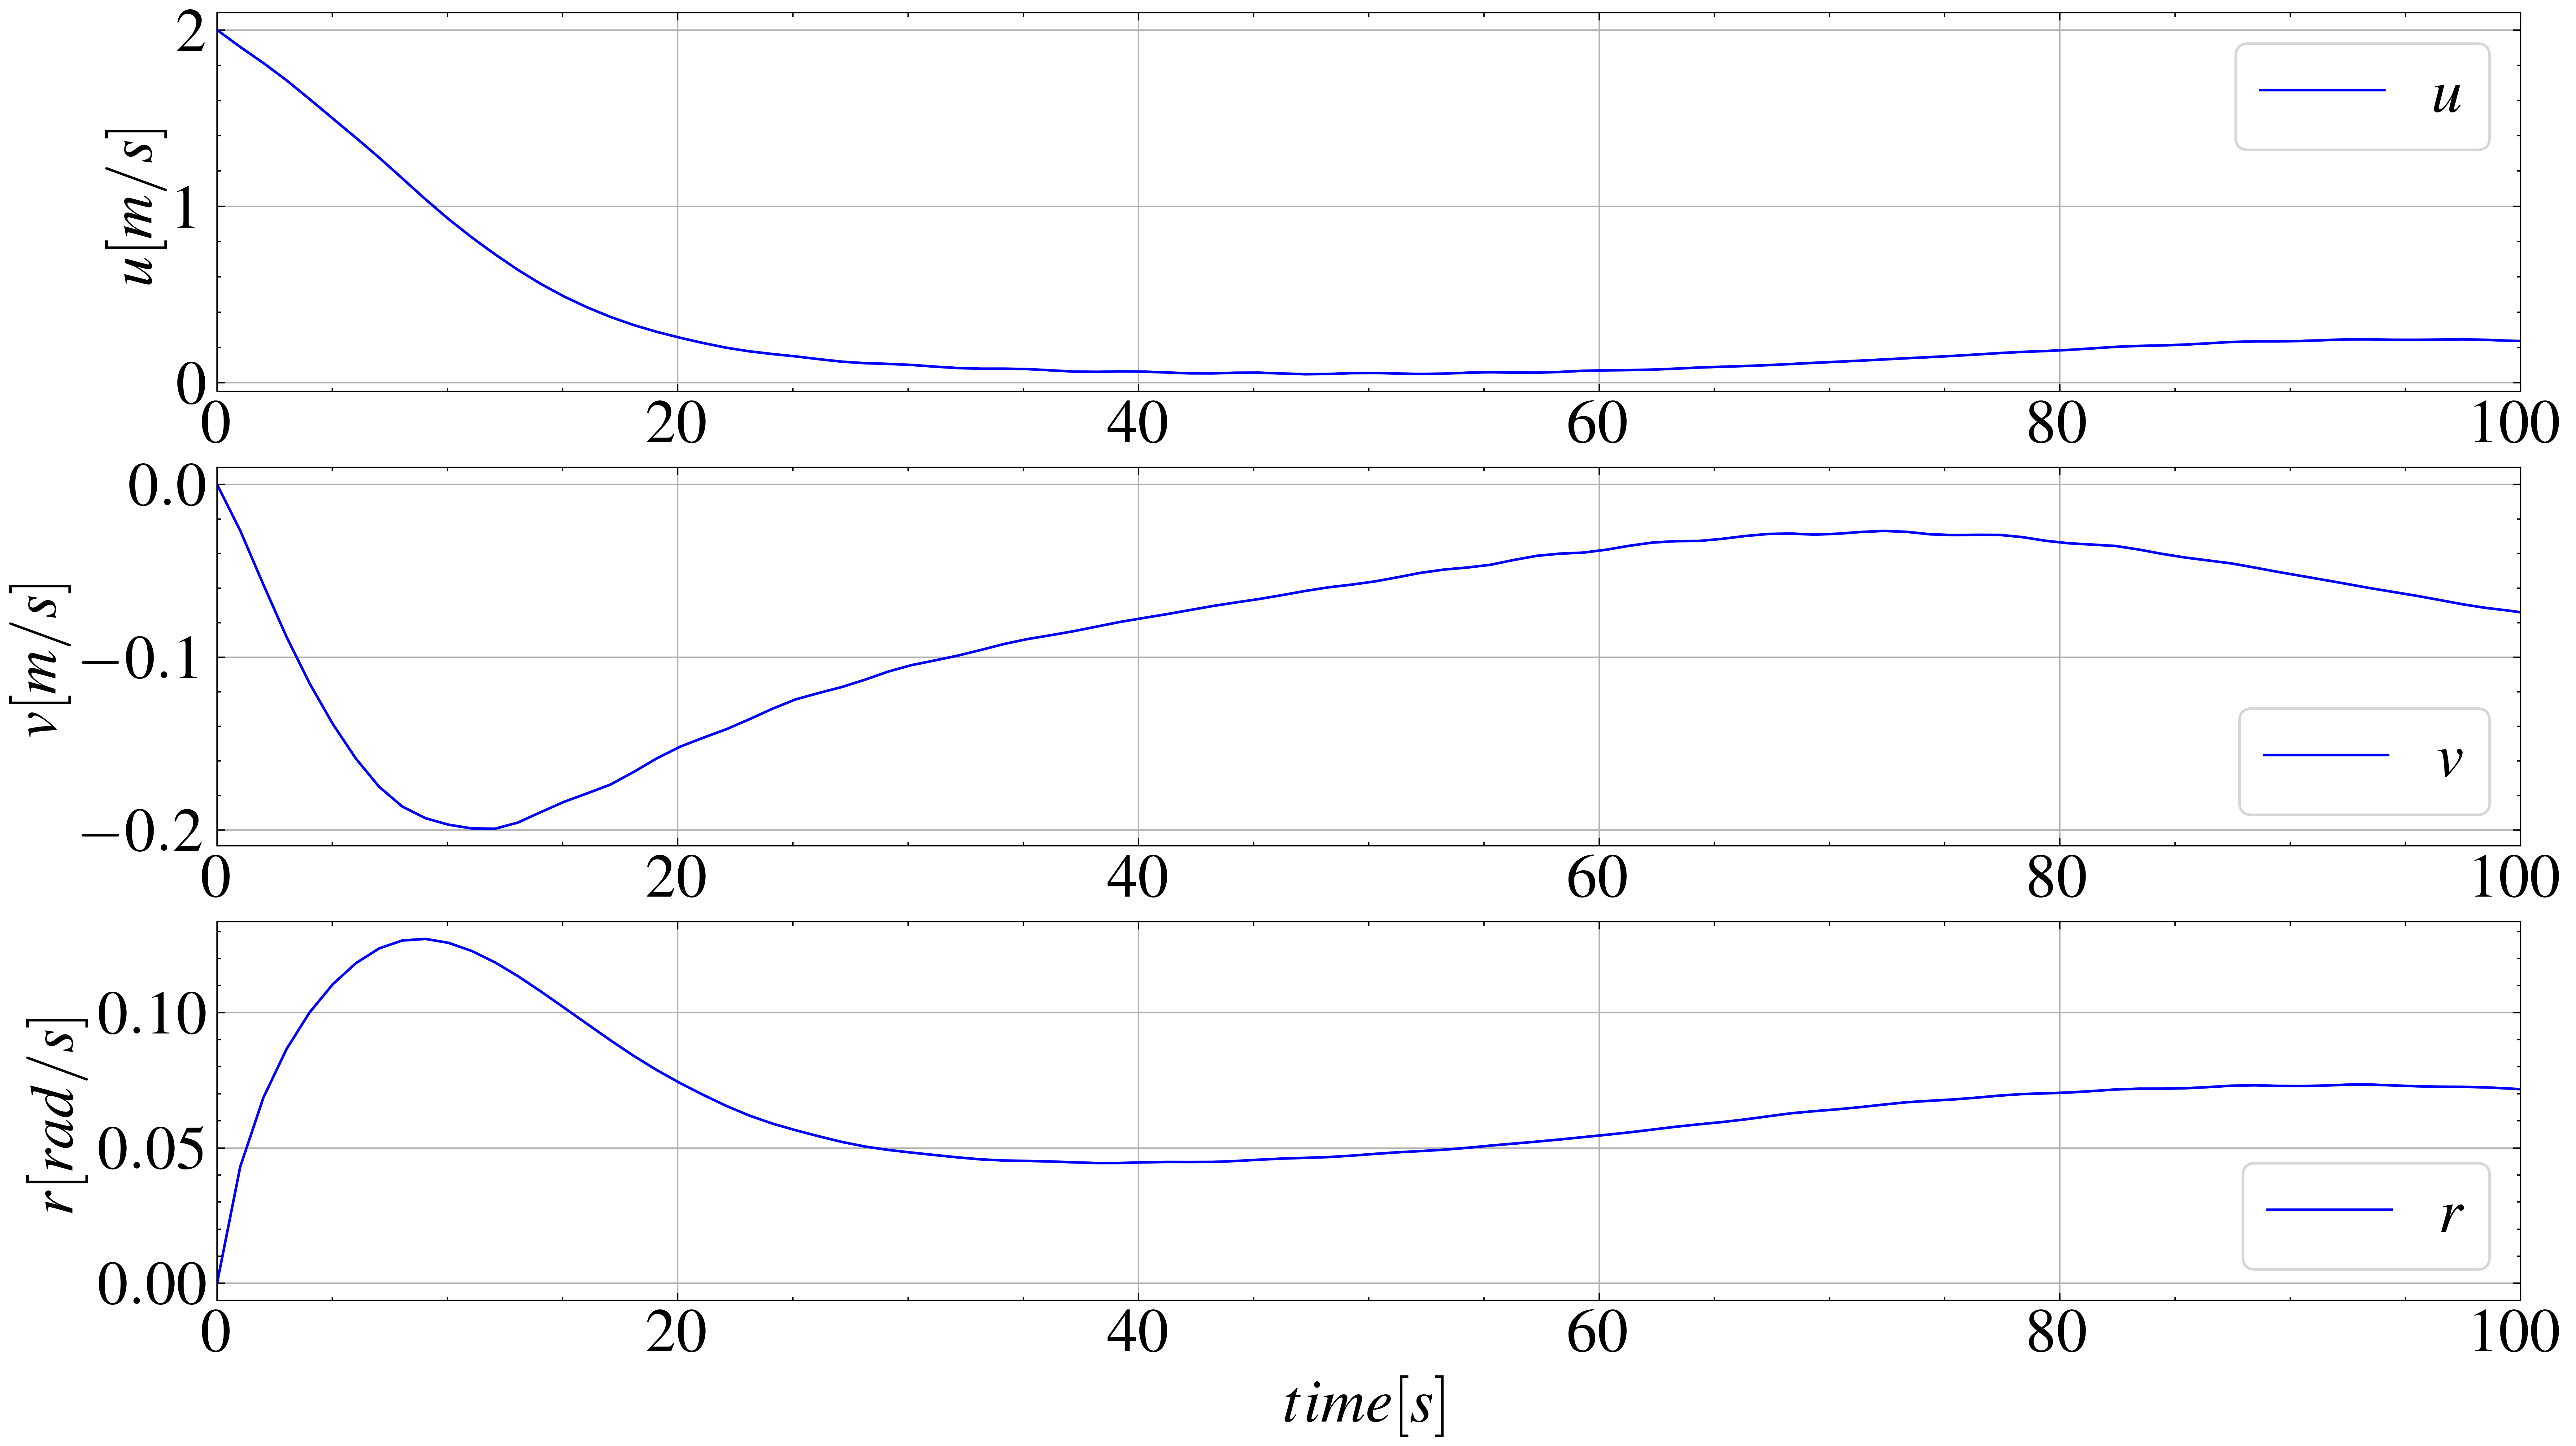

In [13]:
fig = plt.figure()
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(time_list, result[0], label="$u$", c='b')
ax1.set_ylabel("$u[m/s]$", fontsize=24)
ax1.set_xlim(0, 100)
ax1.grid()
ax1.legend(frameon=True, fontsize=24)
plt.tick_params(labelsize=24)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(time_list, result[1], label="$v$", c='b')
ax2.set_ylabel("$v[m/s]$", fontsize=24)
ax2.set_xlim(0, 100)
ax2.grid()
ax2.legend(frameon=True, fontsize=24)
plt.tick_params(labelsize=24)
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(time_list, result[2], label="$r$", c='b')
ax3.set_xlabel("$time[s]$", fontsize=24)
ax3.set_ylabel("$r[rad/s]$", fontsize=24)
ax3.set_xlim(0, 100)
ax3.grid()
ax3.legend(loc='lower right', frameon=True, fontsize=24)
plt.tick_params(labelsize=24)
fig.show()

(-0.5, 2.0)

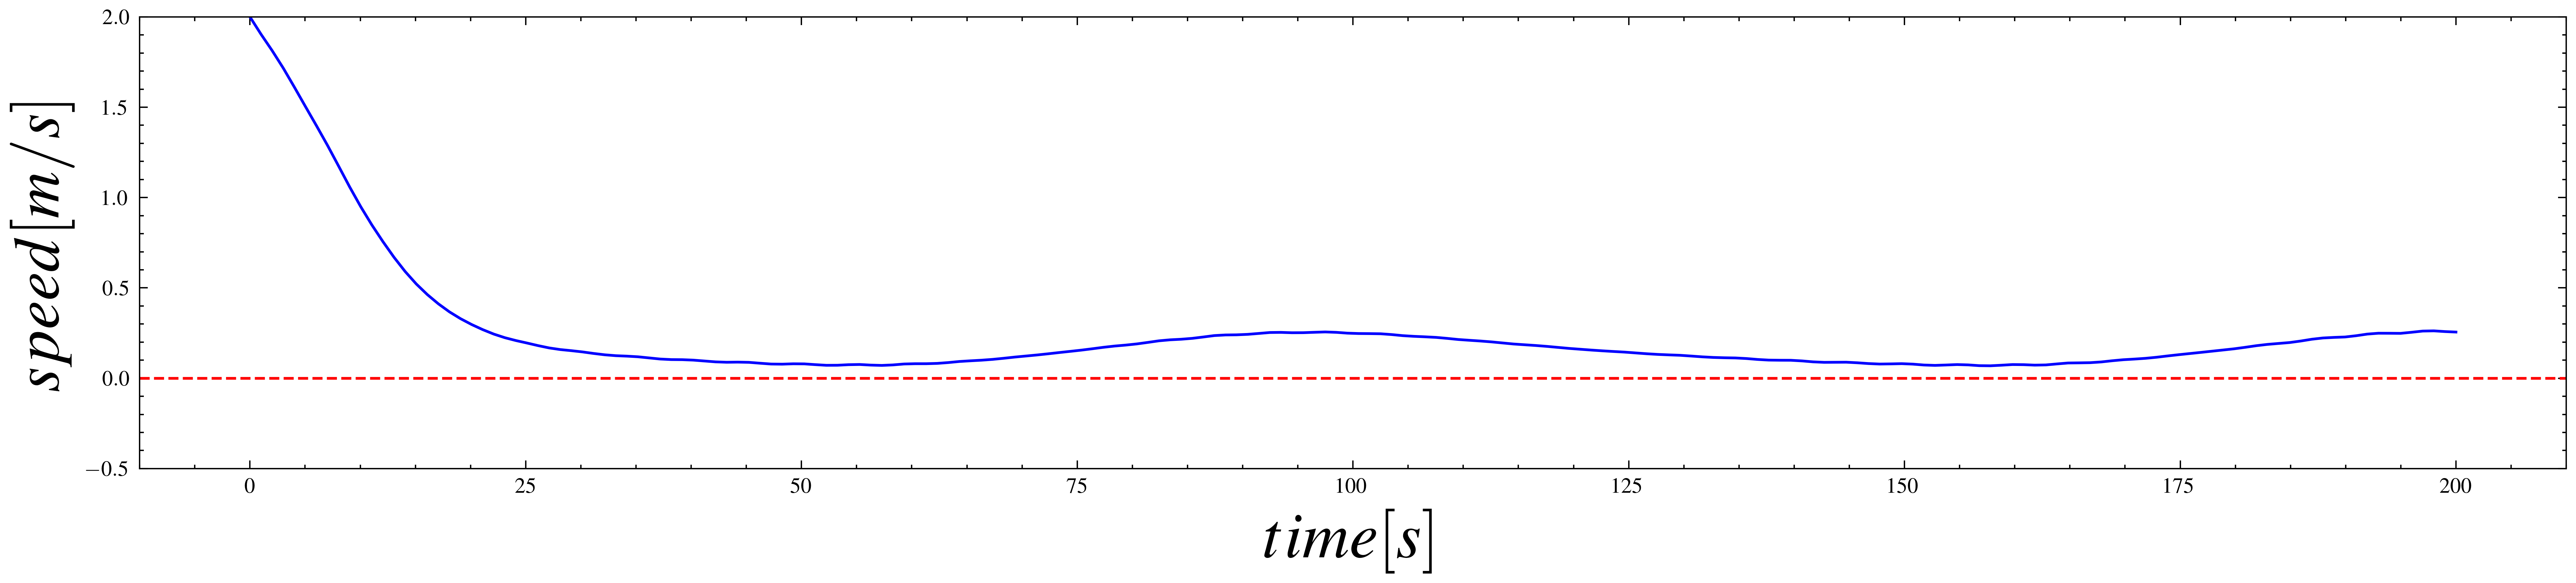

In [14]:
fig = plt.figure(figsize=(16, 3))
U = list(map(lambda u, v: np.sqrt(u**2 + v**2), result[0], result[1]))
plt.plot(time_list, U, label='speed', c='b')
plt.xlabel('$time[s]$', fontsize=24)
plt.ylabel('$speed[m/s]$', fontsize=24)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(-0.5, 2)

/Users/harukiyamamoto/.pyenv/versions/3.11.4/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'tight_layout' and 'constrained_layout' cannot be used together. Please use 'layout' parameter
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


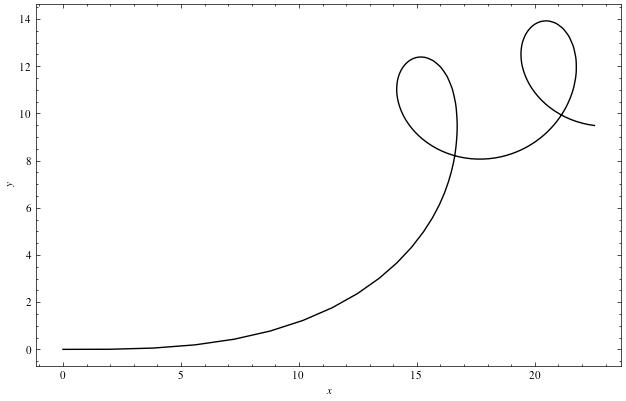

In [15]:
ship.draw_xy_trajectory()

In [16]:
# df_ref = pd.read_csv('observation/suzaku_0EF_35deg.csv')
df_ref = pd.read_csv('observation/suzaku_0EF_20deg.csv')
# df_ref = pd.read_csv('observation/suzaku_0EF_10deg.csv')
df_ref

Unnamed: 0   time_list         u         v         r         x  \
0             0    0.000000  2.000000  0.000000  0.000000  0.000000   
1             1    1.005025  1.874711 -0.054173  0.054392  1.946233   
2             2    2.010050  1.761433 -0.075668  0.062335  3.772716   
3             3    3.015075  1.659299 -0.083361  0.064364  5.486568   
4             4    4.020101  1.567590 -0.085352  0.064240  7.093057   
..          ...         ...       ...       ...       ...       ...   
195         195  195.979899  0.377359 -0.066405  0.055032  6.410052   
196         196  196.984925  0.377322 -0.066388  0.054932  6.257075   
197         197  197.989950  0.377277 -0.066361  0.054774  6.123798   
198         198  198.994975  0.377269 -0.066376  0.054867  6.010791   
199         199  200.000000  0.377254 -0.066380  0.054900  5.918229   

             y        psi         δ  npm  ...   X_R_ref   X_P_ref    Y_H_ref  \
0     0.000000   0.000000  0.349066  9.0  ... -5.962395 -2.618533   0.000000   
1    -0.001718   0.038494  0.349066  9.0  ... -4.430045 -2.191526  30.259242   
2     0.054237   0.097961  0.349066  9.0  ... -3.811815 -1.773446  35.074644   
3     0.196052   0.161873  0.349066  9.0  ... -3.393144 -1.370327  35.068212   
4     0.424879   0.226537  0.349066  9.0  ... -3.077993 -0.998118  33.461533   
..         ...        ...       ...  ...  ...       ...       ...        ...   
195  23.090928  10.733559  0.349066  9.0  ... -0.850175  3.162826   7.610101   
196  22.737595  10.788858  0.349066  9.0  ... -0.850655  3.163578   7.598365   
197  22.376384  10.844216  0.349066  9.0  ... -0.851429  3.164732   7.579972   
198  22.008400  10.899325  0.349066  9.0  ... -0.850943  3.164152   7.590223   
199  21.634761  10.954493  0.349066  9.0  ... -0.850758  3.163984   7.593657   

       Y_R_ref    N_H_ref    N_R_ref     x_bow      y_bow   x_stern    y_stern  
0   -16.381546  -0.000000  32.608076  1.750000   0.000000 -1.750000   0.000000  
1   -12.171448 -21.656814  24.227719  3.694936   0.065630  0.197529  -0.069066  
2   -10.472874 -20.141922  20.846645  5.514326   0.225395  2.031106  -0.116921  
3    -9.322588 -18.474587  18.556956  7.213690   0.478094  3.759446  -0.085991  
4    -8.456716 -17.005505  16.833407  8.798345   0.817936  5.387769   0.031822  
..         ...        ...        ...       ...        ...       ...        ...  
195  -2.335837  -4.669160   4.649570  5.956753  21.400655  6.863351  24.781200  
196  -2.337155  -4.653508   4.652194  5.897893  21.024852  6.616257  24.450338  
197  -2.339283  -4.628782   4.656430  5.859931  20.646391  6.387665  24.106376  
198  -2.337946  -4.643126   4.653768  5.842614  20.266500  6.178968  23.750301  
199  -2.337438  -4.648135   4.652758  5.846358  19.886237  5.990100  23.383284  

[200 rows x 21 columns]

In [17]:
# 外力が常に一定の場合
X_F0 = np.ones(len(time_list)) * 5.0
Y_F0 = np.ones(len(time_list)) * 0

# 線形に外力が変化する場合
# x_f0_initial = 0.0
# x_f0_final = 2.0
# X_F0 = x_f0_initial + (x_f0_final - x_f0_initial) / 150 * ship_kt.time
# Y_F0 = np.ones(run_time) * 0

# 外力がガウス分布に従う場合
# X_F0 = 2.0 * np.exp(-(ship_kt.time-75)**2/100)
# Y_F0 = np.ones(run_time) * 0

X_F = list(
    map(
        lambda X_F0, Y_F0, psi:
        X_F0 * np.cos(psi) + Y_F0 * np.sin(psi)
        ,
        X_F0,
        Y_F0,
        result[5]
    )
)
Y_F = list(
    map(
        lambda X_F0, Y_F0, psi:
        -X_F0 * np.sin(psi) + Y_F0 * np.cos(psi)
        ,
        X_F0,
        Y_F0,
        result[5]
    )
)
N_F = list(map(lambda y: y * np.abs(x_G), Y_F))

In [18]:
# X_ratio = list(map(lambda X_F, X_P: X_F / X_P, X_F, X_P_list))
# Y_ratio = list(map(lambda Y_F, Y_H, Y_R: Y_F / (Y_H + Y_R), Y_F, Y_H_list, Y_R_list))
# N_ratio = list(map(lambda N_F, N_H, N_R: N_F / (N_H + N_R), N_F, N_H_list, N_R_list))

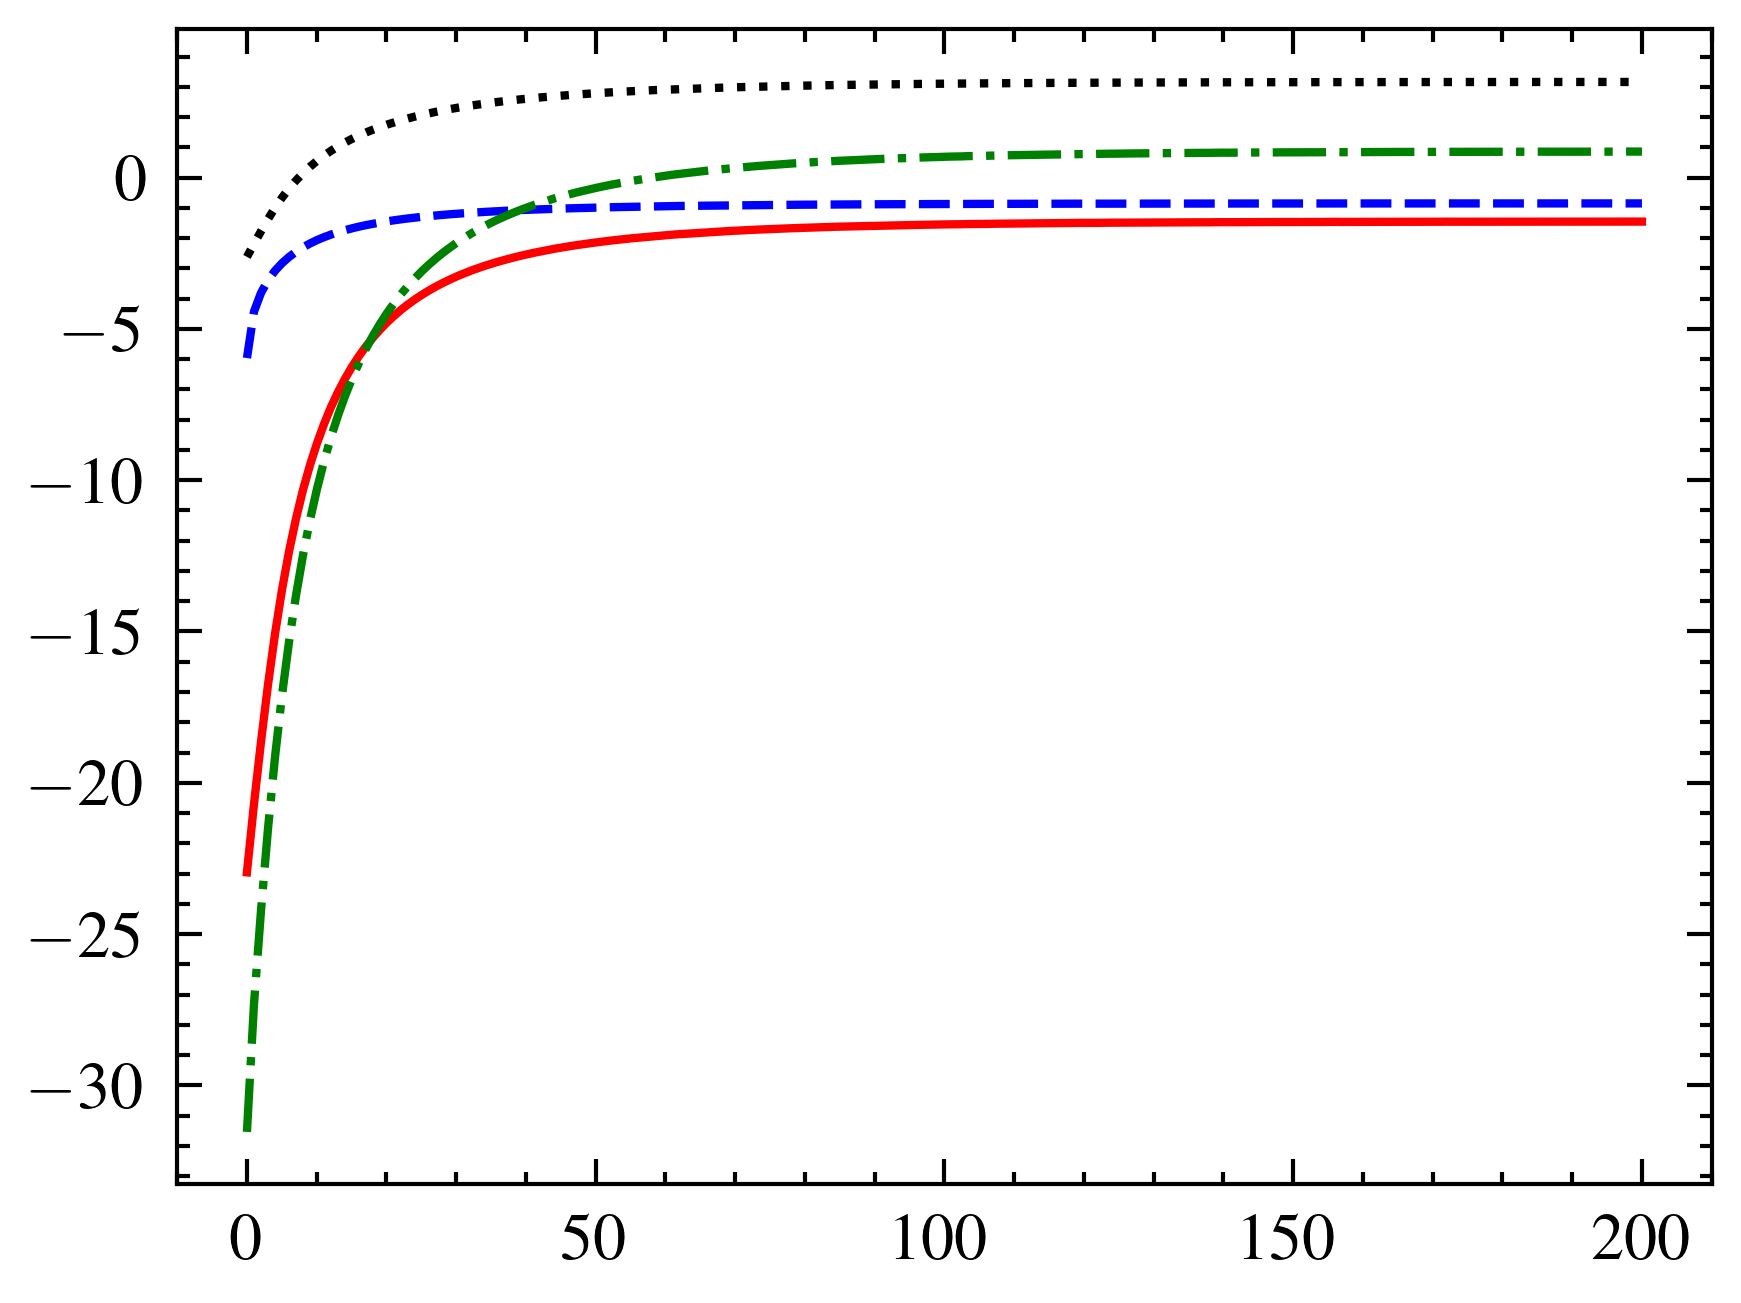

In [19]:
plt.plot(time_list, df_ref['X_H_ref'], c = 'r')
plt.plot(time_list, df_ref['X_R_ref'], c = 'b')
plt.plot(time_list, df_ref['X_P_ref'], c = 'k')
plt.plot(time_list, df_ref['X_H_ref'] + df_ref['X_R_ref'] + df_ref['X_P_ref'], c = 'g')

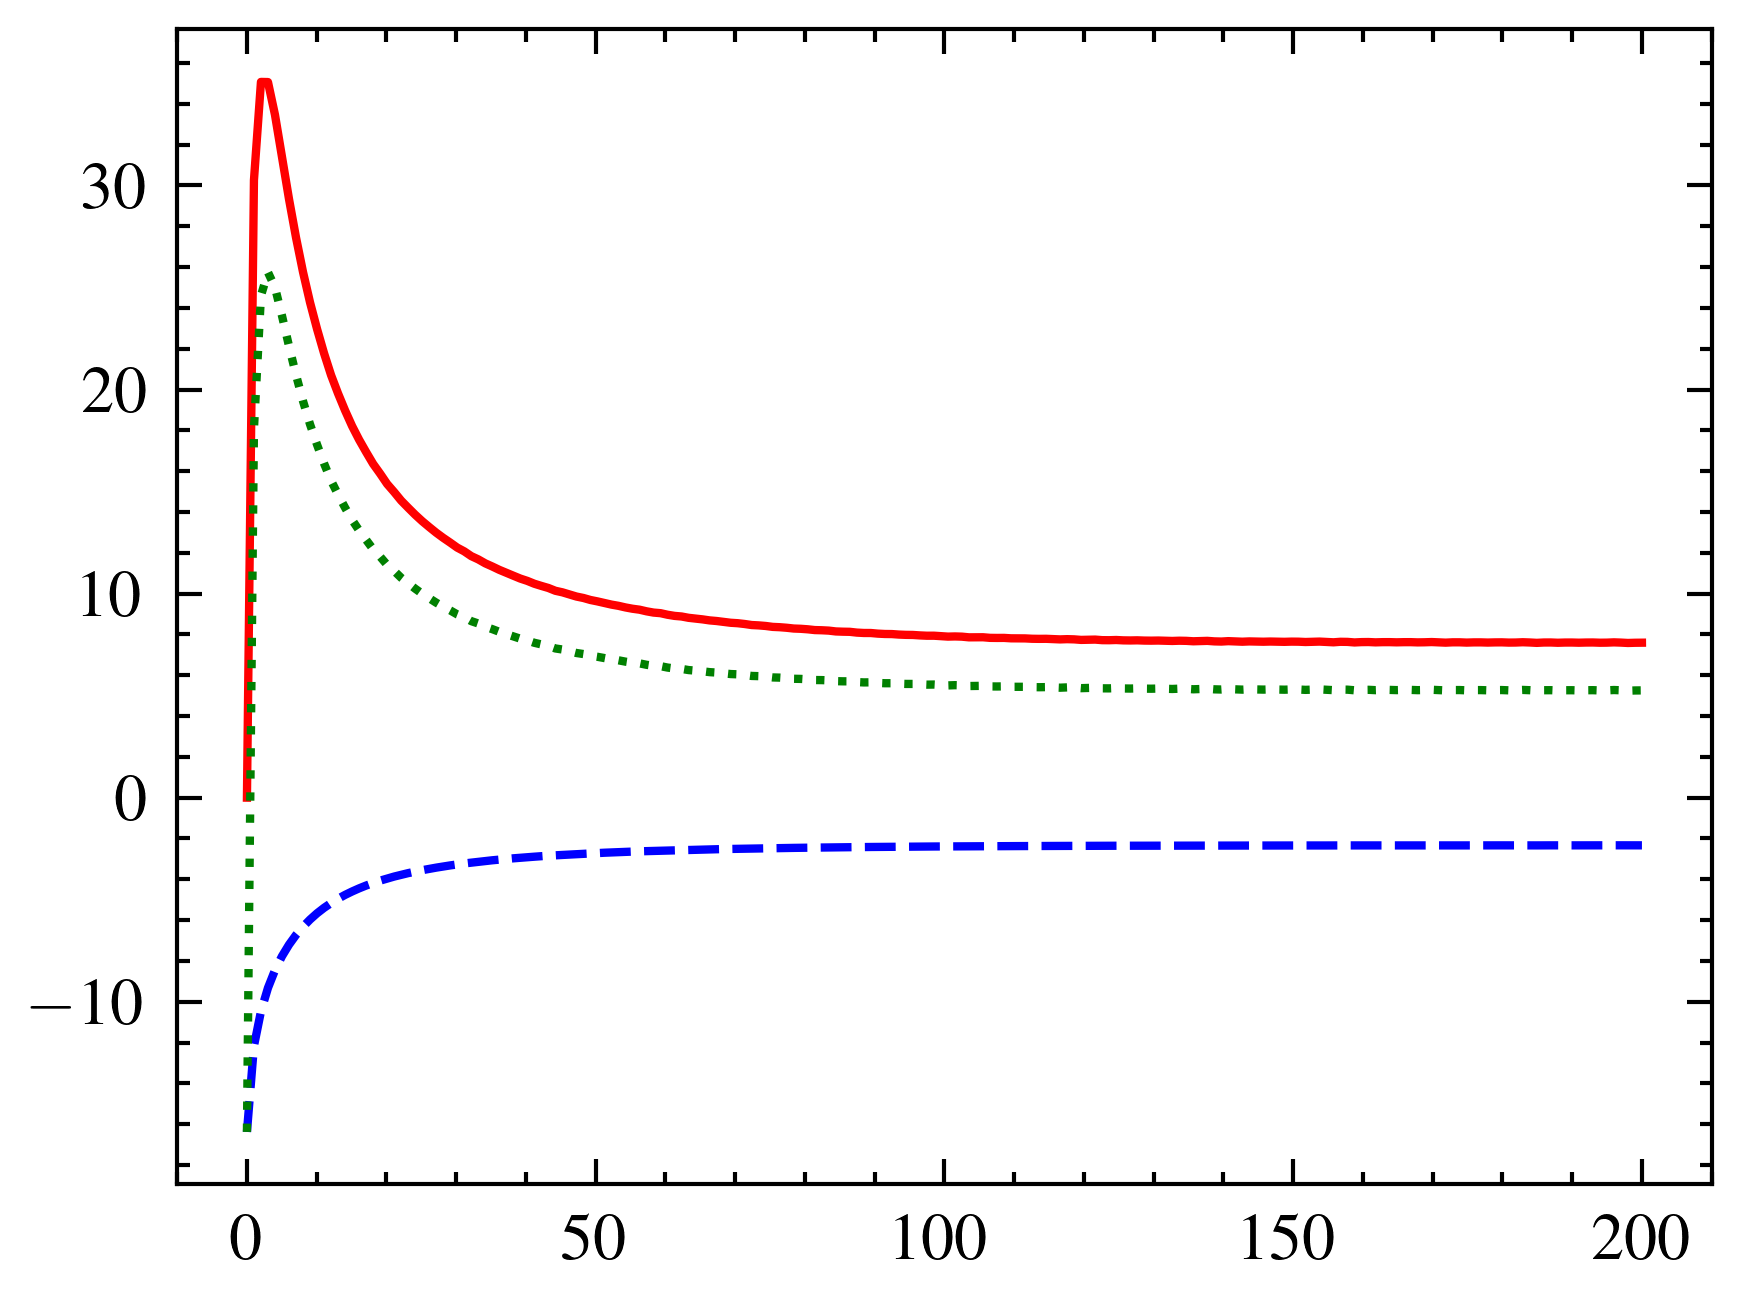

In [20]:
plt.plot(time_list, df_ref['Y_H_ref'], c = 'r')
plt.plot(time_list, df_ref['Y_R_ref'], c = 'b')
plt.plot(time_list, df_ref['Y_H_ref'] + df_ref['Y_R_ref'], c = 'g')

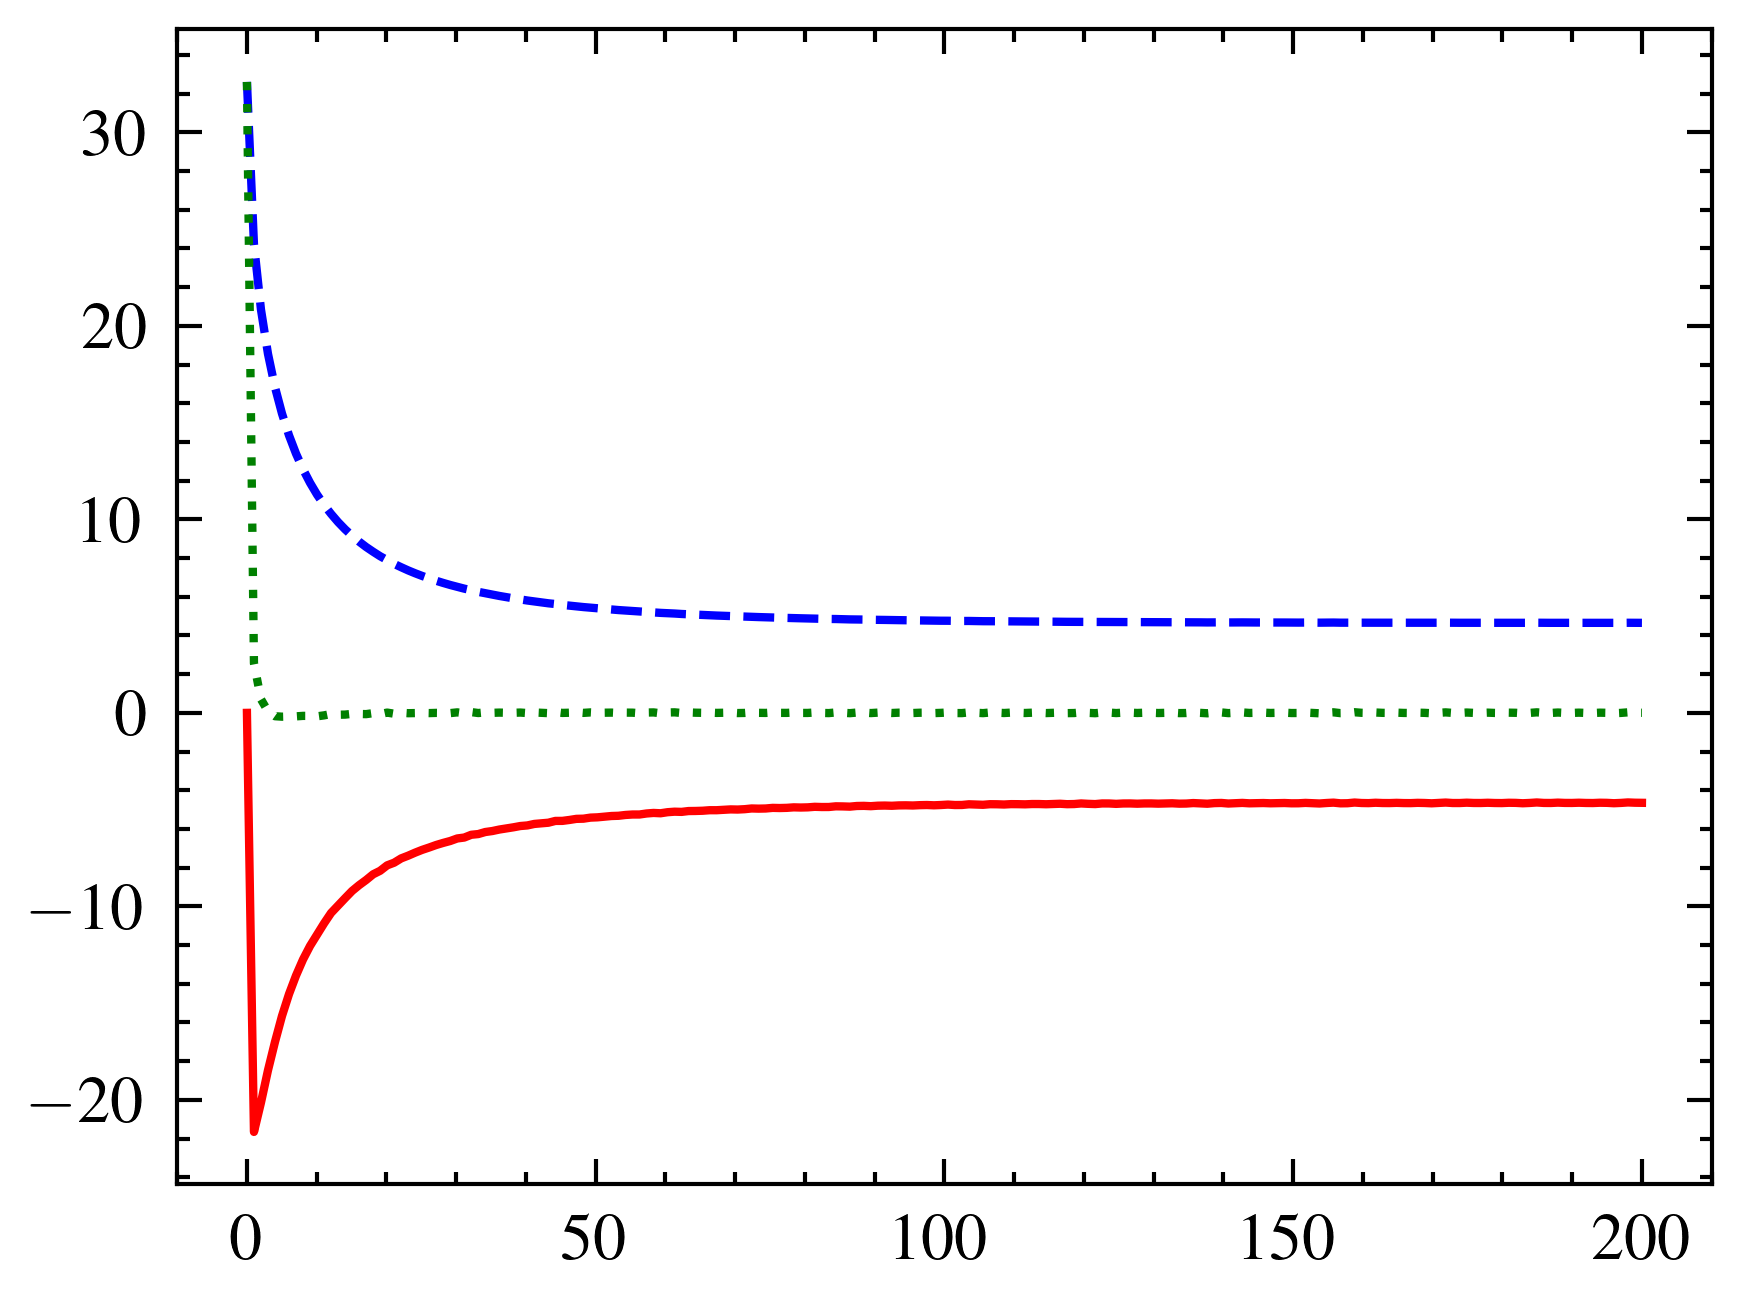

In [21]:
plt.plot(time_list, df_ref['N_H_ref'], c = 'r')
plt.plot(time_list, df_ref['N_R_ref'], c = 'b')
plt.plot(time_list, df_ref['N_H_ref'] + df_ref['N_R_ref'], c = 'g')

In [22]:
# fig = plt.figure()
# fig = plt.figure(figsize=(16, 9))
# ax1 = fig.add_subplot(3, 1, 1)
# ax1.plot(time_list, X_F / (df_ref['X_P']), label="$X_{ratio}$", c='b')
# ax1.set_ylabel("$X_{ratio}$", fontsize=24)
# ax1.set_xlim(0, 100)
# ax1.set_ylim(-2, 2)
# ax1.grid()
# ax1.legend(frameon=True, fontsize=24)
# plt.tick_params(labelsize=24)

# ax2 = fig.add_subplot(3, 1, 2)
# ax2.plot(time_list, Y_F / (df_ref['Y_H'] + df_ref['Y_R']), label="$Y_{ratio}$", c='b')
# ax2.set_ylabel("$Y_{ratio}$", fontsize=24)
# ax2.set_xlim(0, 100)
# ax2.set_ylim(-1, 1)
# ax2.grid()
# ax2.legend(frameon=True, fontsize=24)
# plt.tick_params(labelsize=24)
# fig.show()

# ax3 = fig.add_subplot(3, 1, 3)
# ax3.plot(time_list, N_F / (df_ref['N_H'] + df_ref['N_R']), label="$r_{ratio}$", c='b')
# ax3.set_xlabel("time[s]", fontsize=24)
# ax3.set_ylabel("$r_{ratio}$", fontsize=24)
# ax3.set_xlim(0, 100)
# ax3.set_ylim(-1, 1)
# ax3.grid()
# ax3.legend(loc='lower right', frameon=True, fontsize=24)
# plt.tick_params(labelsize=24)
# fig.show()

In [23]:
data1 = pd.read_csv('suzaku_data_freq/suzaku_0weight_5t_20deg_1hz.csv')
data2 = pd.read_csv('suzaku_data_freq/suzaku_0weight_5t_20deg_2hz.csv')
data4 = pd.read_csv('suzaku_data_freq/suzaku_0weight_5t_20deg_4hz.csv')
data5 = pd.read_csv('suzaku_data_freq/suzaku_0weight_5t_20deg.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'suzaku_data_freq/suzaku_0weight_5t_20deg_1hz.csv'

/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_83926/3884974591.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_83926/3884974591.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


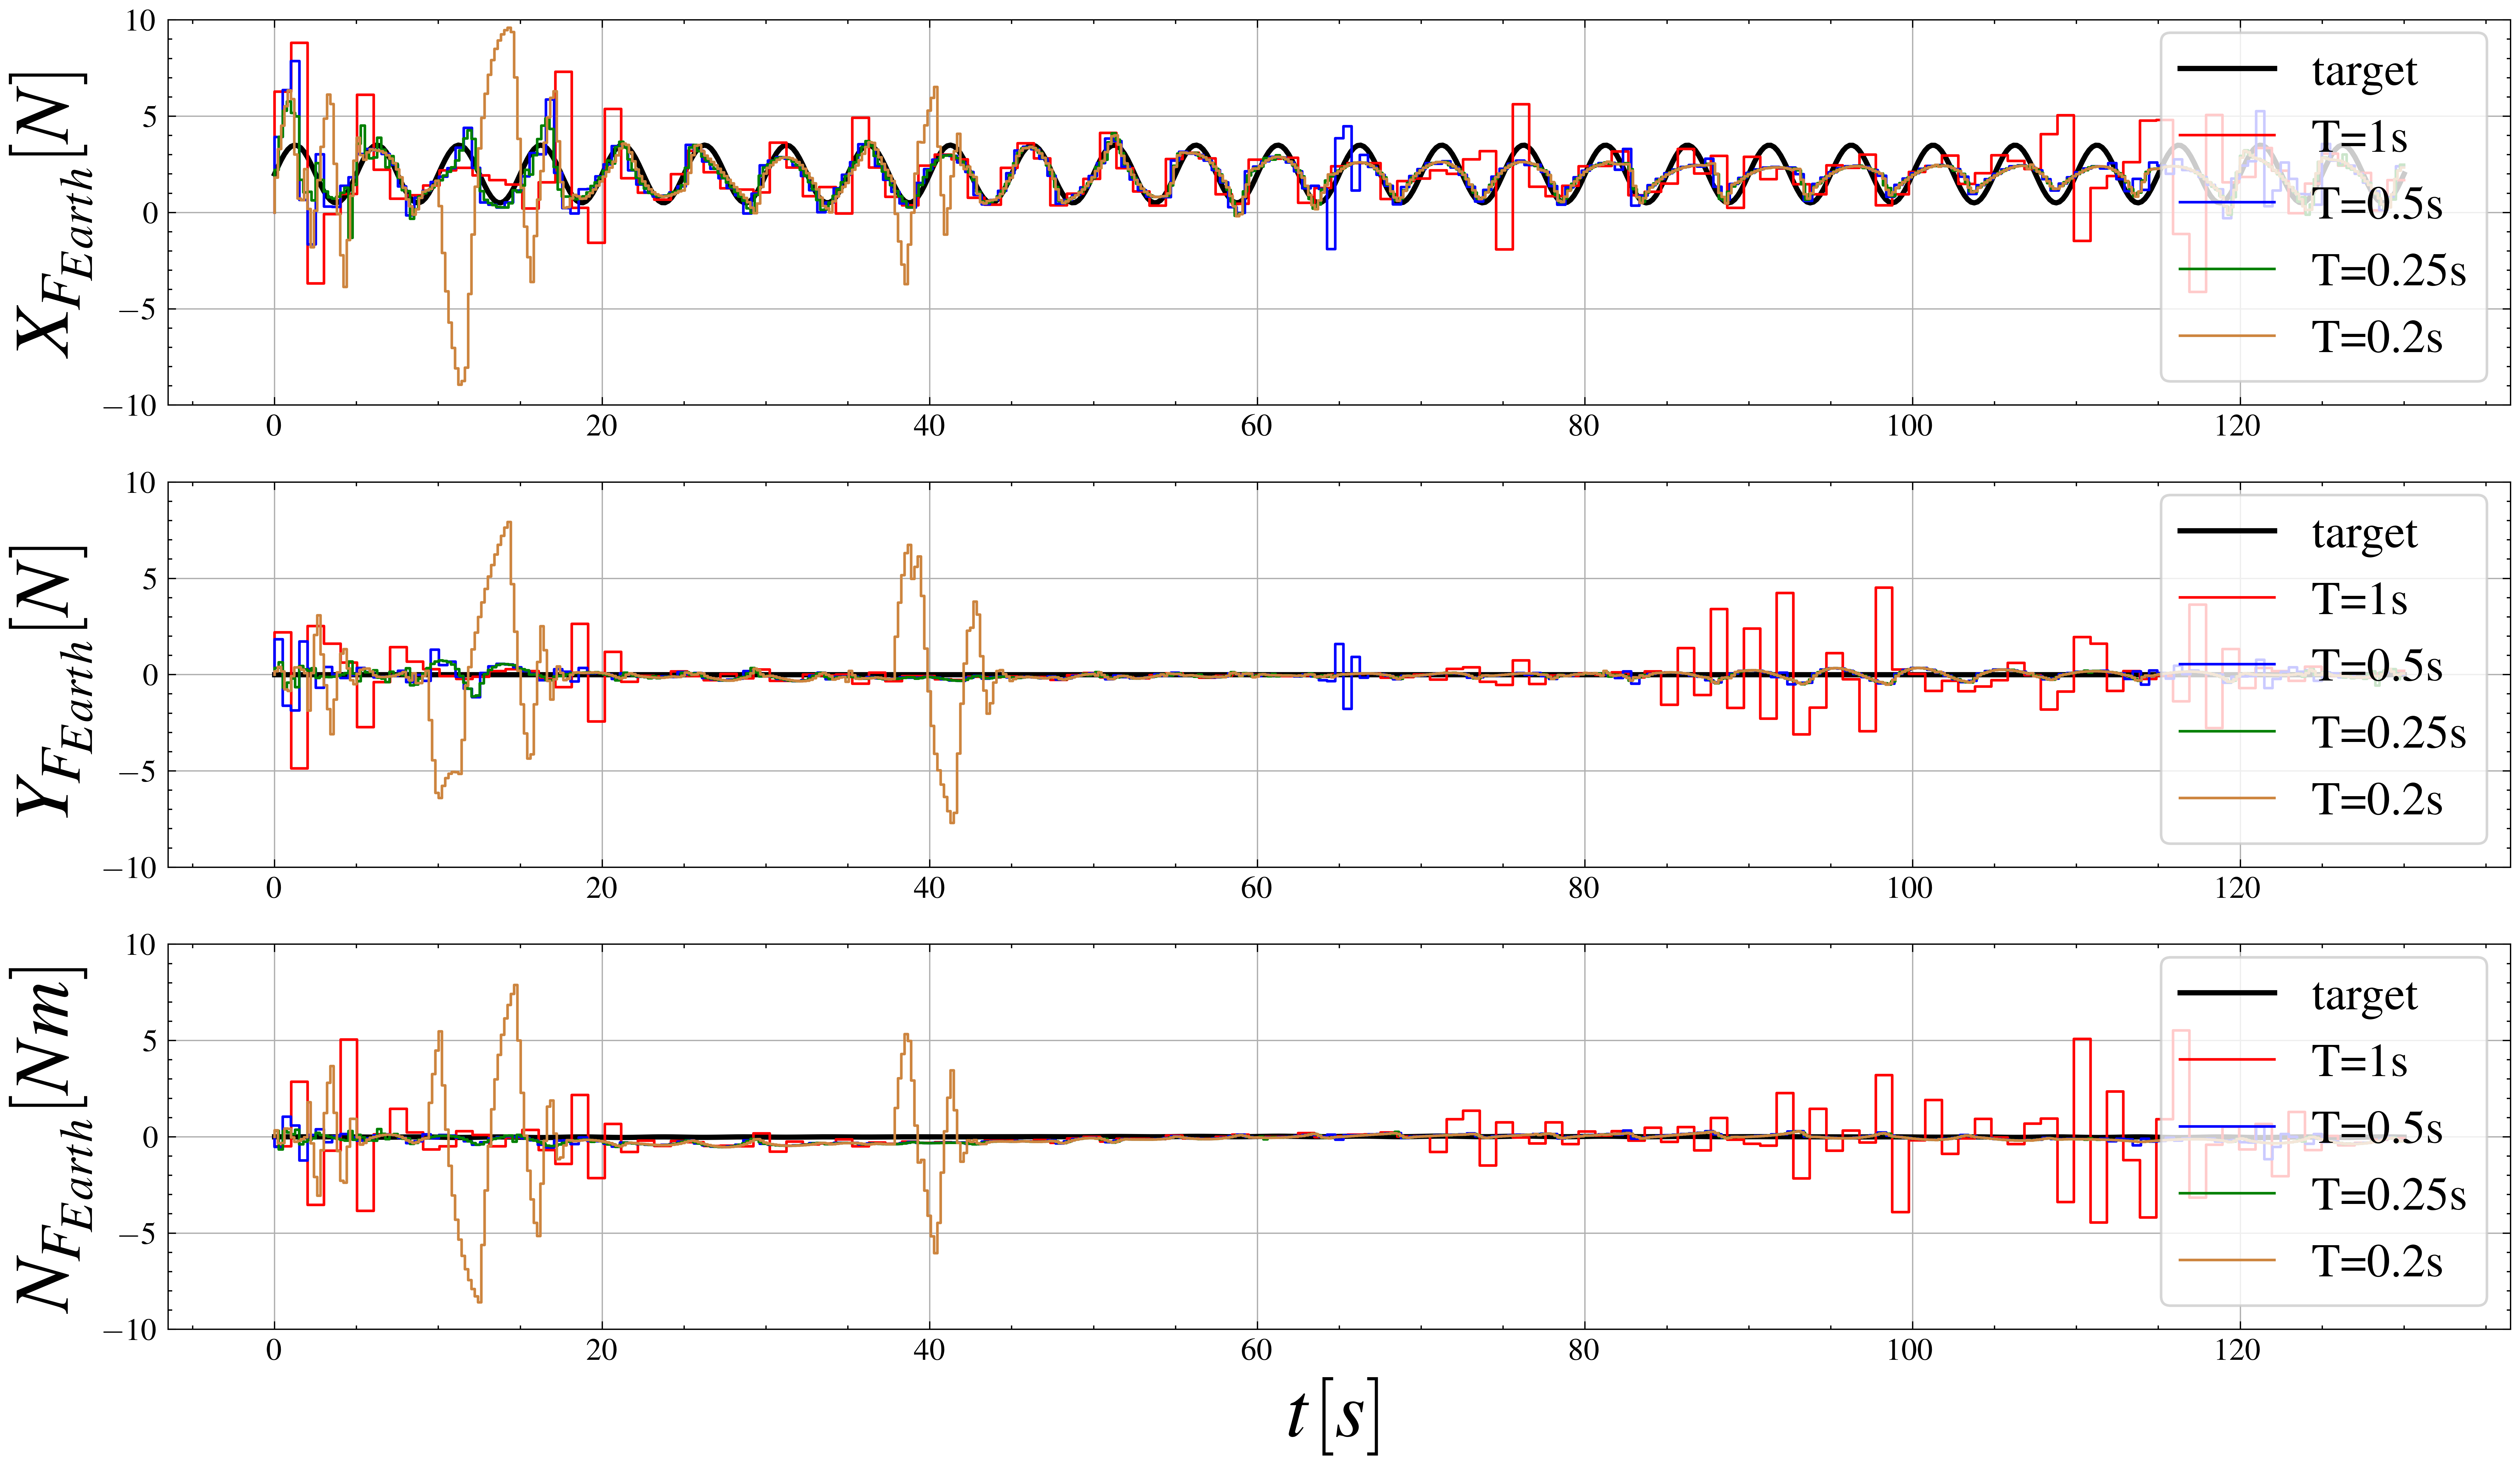

In [29]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(data5['time'], data5['x_F_ref'], label='target', c='k', linewidth=2)
ax1.step(data1['time'], data1['x_F'], label='T=1s', linestyle='-')
ax1.step(data2['time'], data2['x_F'], label='T=0.5s', linestyle='-')
ax1.step(data4['time'], data4['x_F'], label='T=0.25s', linestyle='-')
ax1.step(data5['time'], data5['x_F'], label='T=0.2s', linestyle='-', c='peru')
ax1.set_ylabel('$X_{F_{Earth}}[N]$', fontsize=30)
ax1.set_ylim(-10, 10)
# ax1.set_xlim(0, 20)
ax1.legend(frameon=True, loc='lower right', fontsize=18)
ax1.grid()
plt.tick_params(labelsize=12)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(data5['time'], data5['y_F_ref'], label='target', c='k', linewidth=2)
# ax2.step(data1['time'], data1['y_F'], label='T=1s')
ax2.step(data1['time'], data1['y_F'], label='T=1s', linestyle='-')
ax2.step(data2['time'], data2['y_F'], label='T=0.5s', linestyle='-')
ax2.step(data4['time'], data4['y_F'], label='T=0.25s', linestyle='-')
ax2.step(data5['time'], data5['y_F'], label='T=0.2s', linestyle='-', c='peru')
ax2.set_ylabel('$Y_{F_{Earth}}[N]$', fontsize=30)
ax2.set_ylim(-10, 10)
# ax2.set_xlim(0, 20)
ax2.legend(frameon=True, loc='lower right', fontsize=18)
plt.tick_params(labelsize=12)
ax2.grid()
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(data5['time'], data5['n_F_ref'], label='target', c='k', linewidth=2)
# ax3.step(data1['time'], data1['n_F'], label='T=1s')
ax3.step(data1['time'], data1['n_F'], label='T=1s', linestyle='-')
ax3.step(data2['time'], data2['n_F'], label='T=0.5s', linestyle='-')
ax3.step(data4['time'], data4['n_F'], label='T=0.25s', linestyle='-')
ax3.step(data5['time'], data5['n_F'], label='T=0.2s', linestyle='-', c='peru')
ax3.set_xlabel('$t[s]$', fontsize=30)
ax3.set_ylabel('$N_{F_{Earth}}[Nm]$', fontsize=30)
ax3.set_ylim(-10, 10)
# ax3.set_xlim(0, 20)
ax3.legend(frameon=True, loc='lower right', fontsize=18)
plt.tick_params(labelsize=12)
ax3.grid()
fig.show()

In [30]:
data555 = pd.read_csv('suzaku_data_freq/suzaku_0weight_5t_20deg_5-5-5.csv')
data666 = pd.read_csv('suzaku_data_freq/suzaku_0weight_5t_20deg_6-6-6.csv')
data200 = pd.read_csv('suzaku_data_freq/suzaku_0weight_5t_20deg_2-0-0.csv')

/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_83926/3373817164.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_83926/3373817164.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


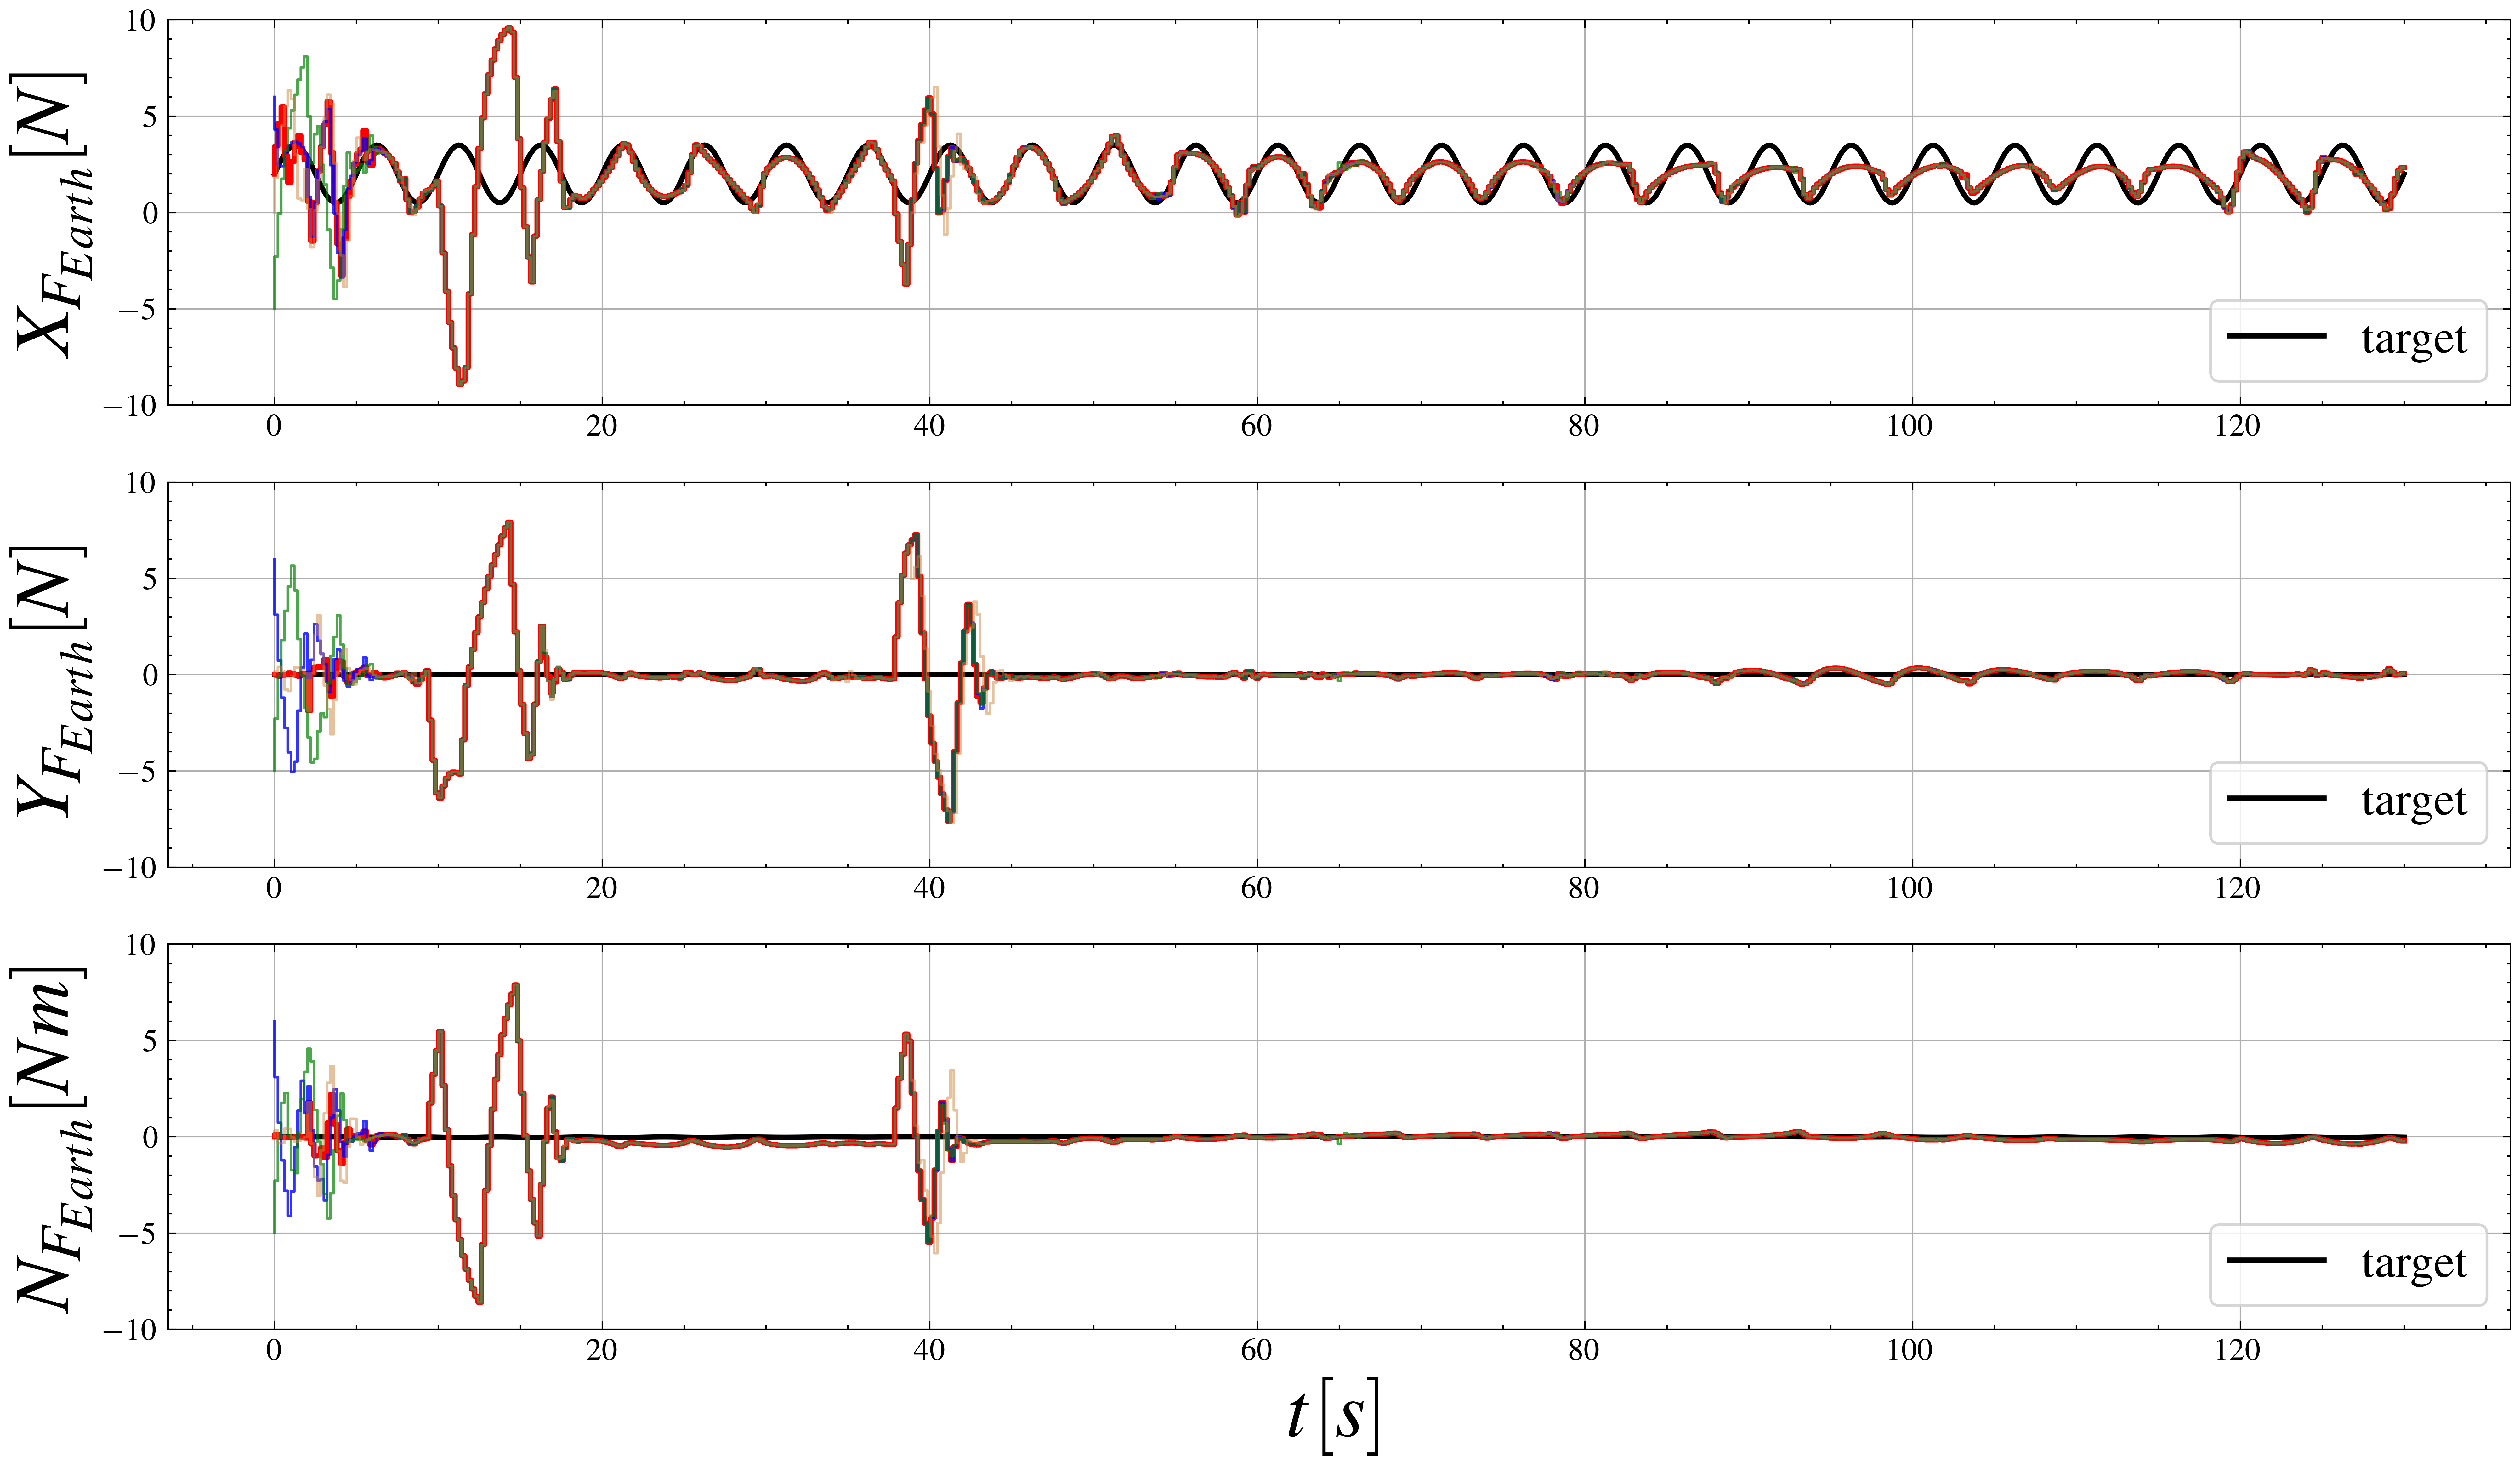

In [31]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(data5['time'], data5['x_F_ref'], label='target', c='k', linewidth=2)
ax1.step(data200['time'], data200['x_F'], linestyle='-', linewidth=2)
ax1.step(data666['time'], data666['x_F'], linestyle='-', alpha=0.8)
ax1.step(data555['time'], data555['x_F'], linestyle='-', alpha=0.7)
ax1.step(data5['time'], data5['x_F'], linestyle='-', c='peru', alpha=0.5)
ax1.set_ylabel('$X_{F_{Earth}}[N]$', fontsize=30)
ax1.set_ylim(-10, 10)
# ax1.set_xlim(0, 20)
ax1.legend(frameon=True, loc='lower right', fontsize=18)
ax1.grid()
plt.tick_params(labelsize=12)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(data5['time'], data5['y_F_ref'], label='target', c='k', linewidth=2)
# ax2.step(data200['time'], data200['y_F'], label='T=1s')
ax2.step(data200['time'], data200['y_F'], linestyle='-', linewidth=2)
ax2.step(data666['time'], data666['y_F'], linestyle='-', alpha=0.8)
ax2.step(data555['time'], data555['y_F'], linestyle='-', alpha=0.7)
ax2.step(data5['time'], data5['y_F'], linestyle='-', c='peru', alpha=0.5)
ax2.set_ylabel('$Y_{F_{Earth}}[N]$', fontsize=30)
ax2.set_ylim(-10, 10)
# ax2.set_xlim(0, 20)
ax2.legend(frameon=True, loc='lower right', fontsize=18)
plt.tick_params(labelsize=12)
ax2.grid()
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(data5['time'], data5['n_F_ref'], label='target', c='k', linewidth=2)
# ax3.step(data200['time'], data200['n_F'], label='T=1s')
ax3.step(data200['time'], data200['n_F'], linestyle='-', linewidth=2)
ax3.step(data666['time'], data666['n_F'], linestyle='-', alpha=0.8)
ax3.step(data555['time'], data555['n_F'], linestyle='-', alpha=0.7)
ax3.step(data5['time'], data5['n_F'], linestyle='-', c='peru', alpha=0.5)
ax3.set_xlabel('$t[s]$', fontsize=30)
ax3.set_ylabel('$N_{F_{Earth}}[Nm]$', fontsize=30)
ax3.set_ylim(-10, 10)
# ax3.set_xlim(0, 20)
ax3.legend(frameon=True, loc='lower right', fontsize=18)
plt.tick_params(labelsize=12)
ax3.grid()
fig.show()

In [32]:
duration = 200
num_of_sampling = 201
time_list = np.linspace(0.00, duration, num_of_sampling)
time_list

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

## Zig-Zag

In [33]:
target_δ_rad = 10.0 * np.pi / 180.0
target_ψ_rad_deviation = 10.0 * np.pi / 180.0
duration = 200
num_of_sampling = 201
time_list = np.linspace(0.00, duration, num_of_sampling)
n_const = 9.0  # [rpm]
npm_list = np.array([n_const for i in range(num_of_sampling)])

δ_list, u_list, v_list, r_list, x_list, y_list, ψ_list = zigzag_test_mmg_3dof(
    basic_params,
    maneuvering_params,
    target_δ_rad,
    target_ψ_rad_deviation,
    time_list,
    npm_list,
    δ_rad_rate=10.0 * np.pi / 180,
    # u0 = 0
)

ship = ShipObj3dof(L=basic_params.L_pp, B=basic_params.B)
ship.load_simulation_result(time_list, u_list, v_list, r_list)
ship.δ = δ_list
ship.npm = npm_list

ship2 = ShipObj3dof(L=basic_params.L_pp, B=basic_params.B)
ship2.register_simulation_result(time_list, u_list, v_list, r_list, x_list, y_list, ψ_list)
ship2.δ = δ_list
ship2.npm = npm_list

/Users/harukiyamamoto/.pyenv/versions/3.11.4/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `s0`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


### OUTPUT

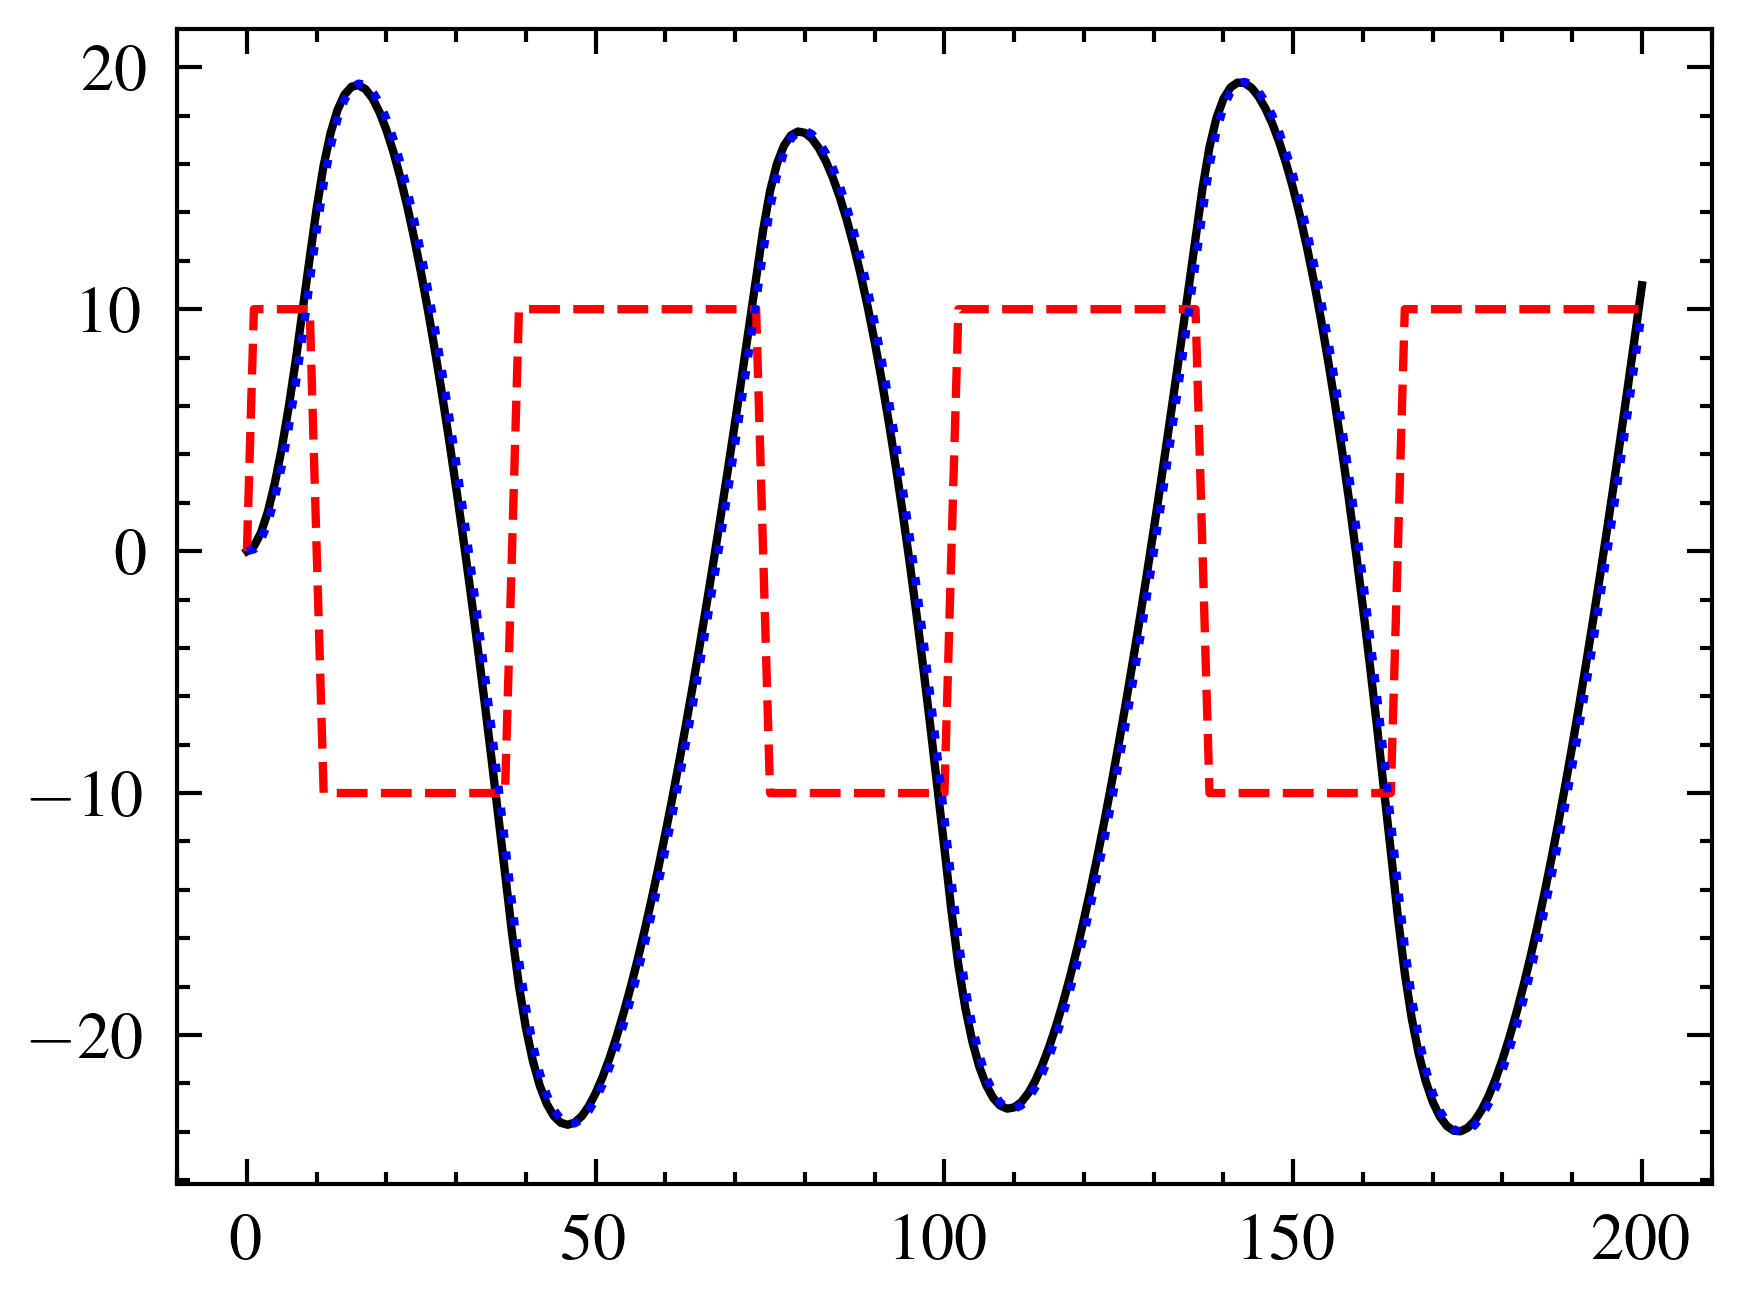

In [36]:
import matplotlib.pyplot as plt
plt.plot(time_list, list(map(lambda psi: psi * 180 / np.pi, ship.psi)))
plt.plot(time_list, list(map(lambda δ: δ * 180 / np.pi, ship.δ)))
plt.plot(time_list, list(map(lambda psi: psi * 180 / np.pi, ψ_list)))

In [37]:
(
    X_H_list,
    X_R_list,
    X_P_list,
    Y_H_list,
    Y_R_list,
    N_H_list,
    N_R_list,
    U_list,
    β_list,
    v_dash_list,
    r_dash_list,
    β_P_list,
    w_P_list,
    J_list,
    K_T_list,
    β_R_list,
    γ_R_list,
    v_R_list,
    u_R_list,
    U_R_list,
    α_R_list,
    F_N_list,
) = get_sub_values_from_simulation_result(
    ship.u,
    ship.v,
    ship.r,
    ship.δ,
    ship.npm,
    basic_params,
    maneuvering_params,
    return_all_vals=True,
)

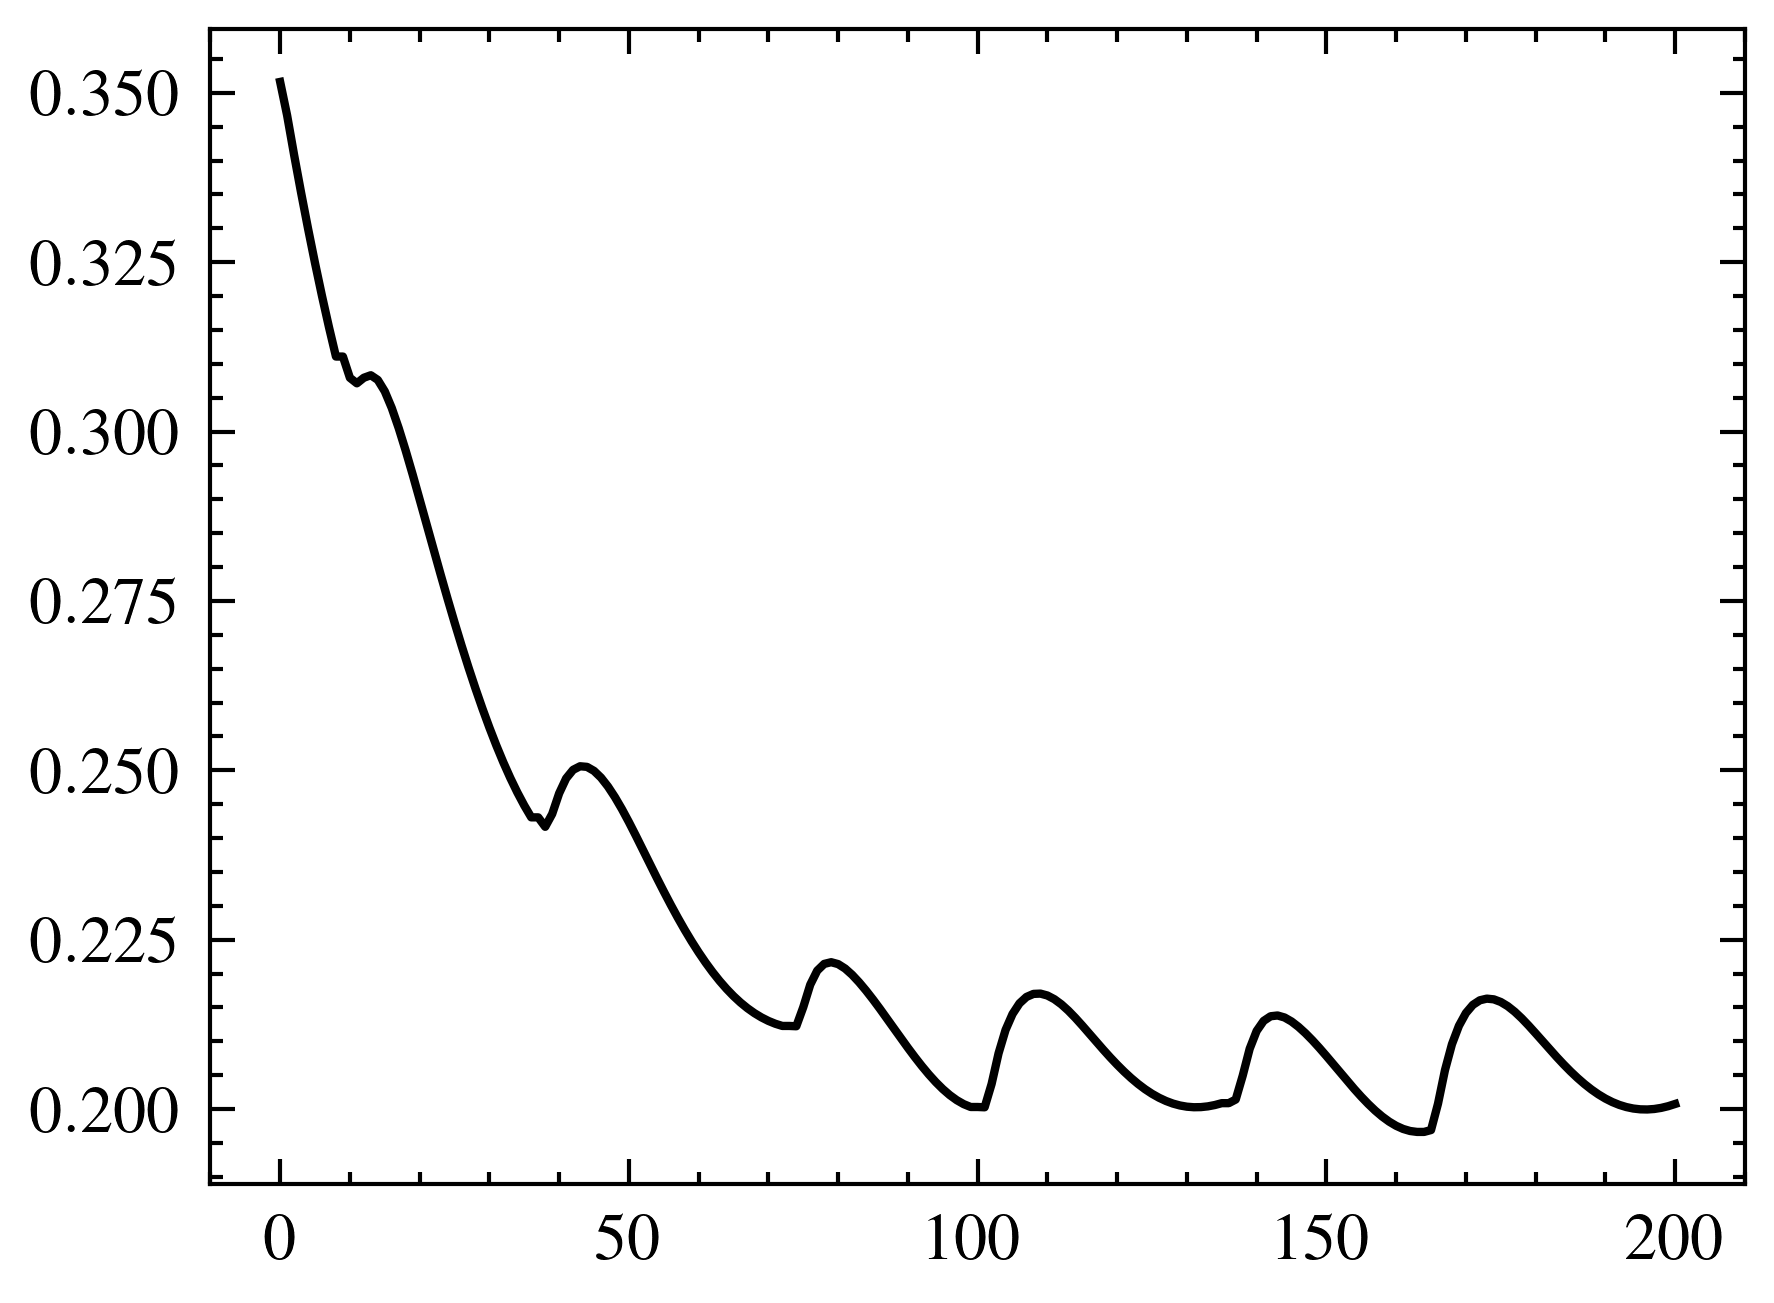

In [38]:
plt.plot(time_list,K_T_list)

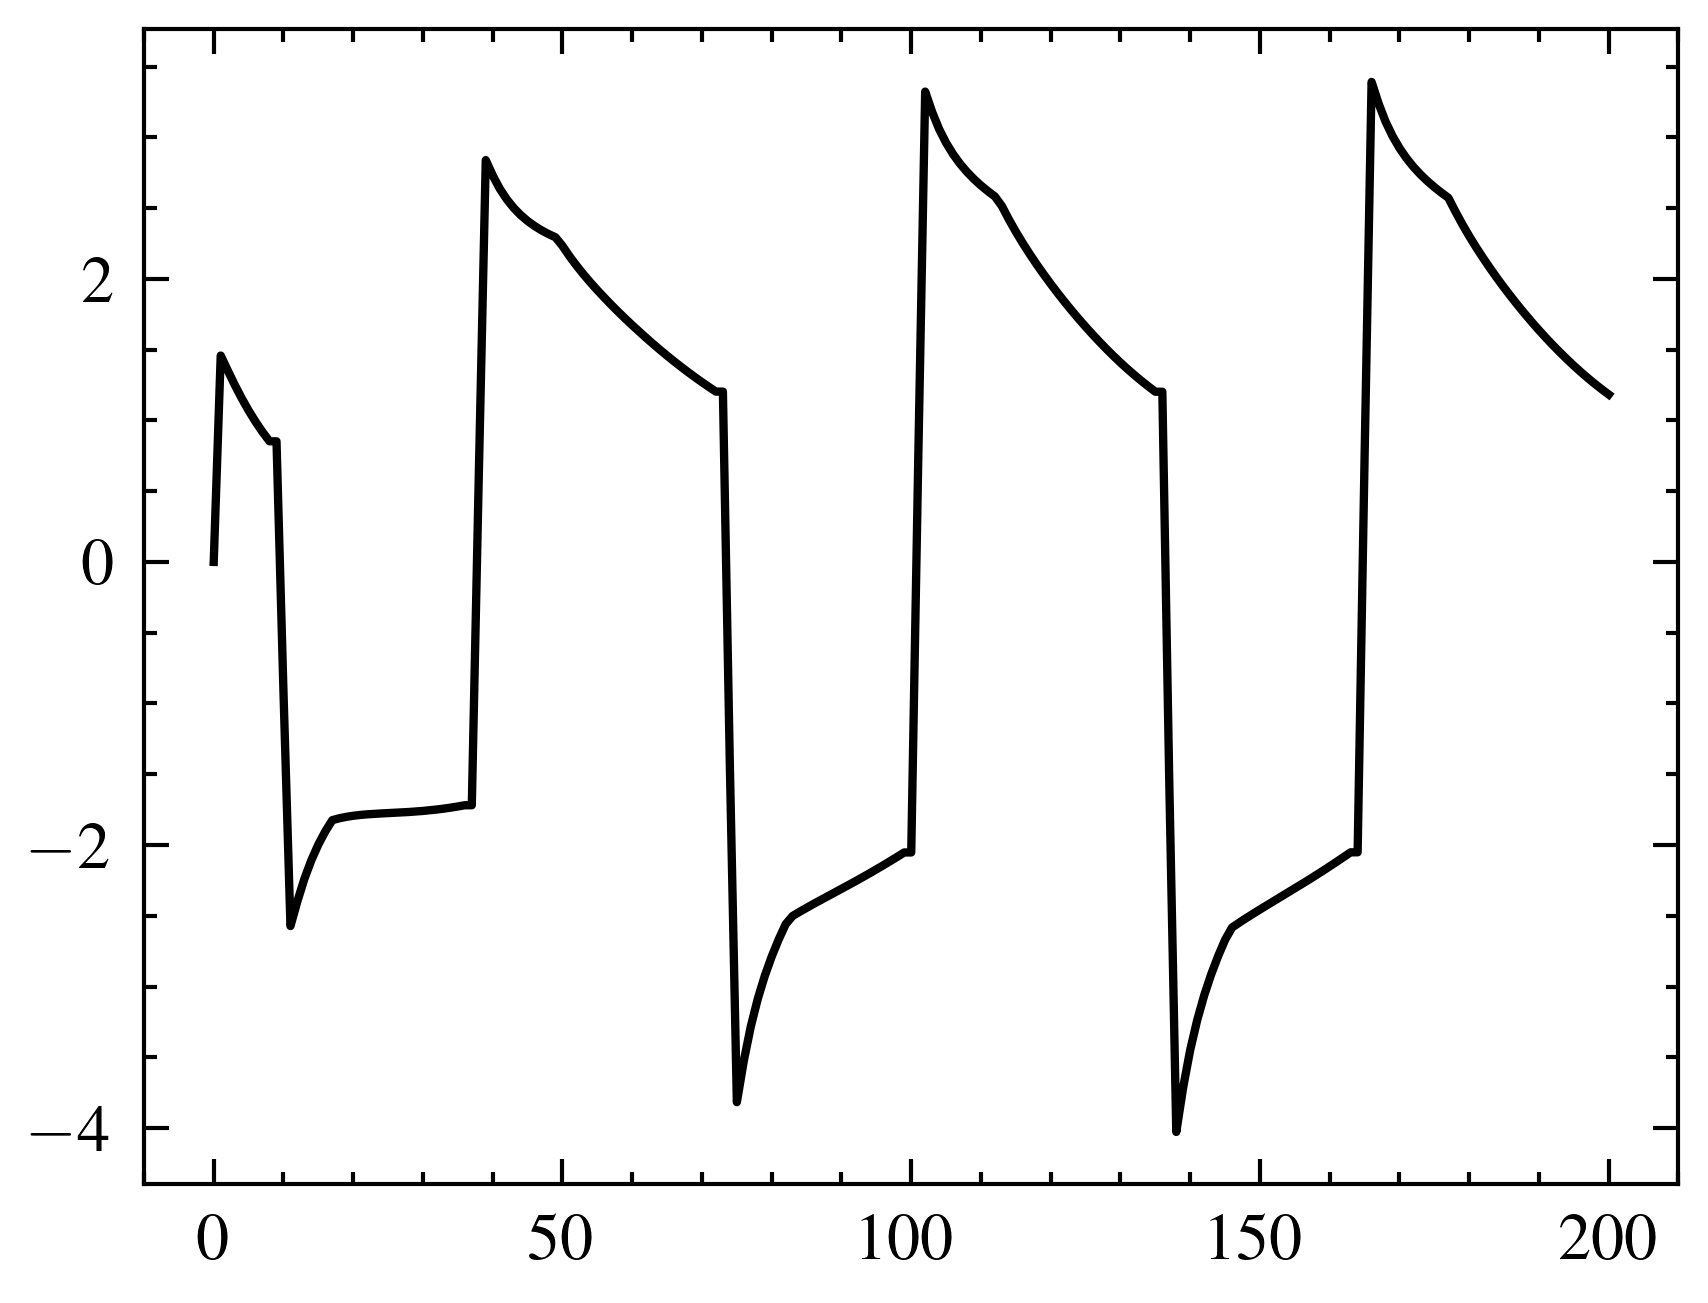

In [39]:
plt.plot(time_list,F_N_list)

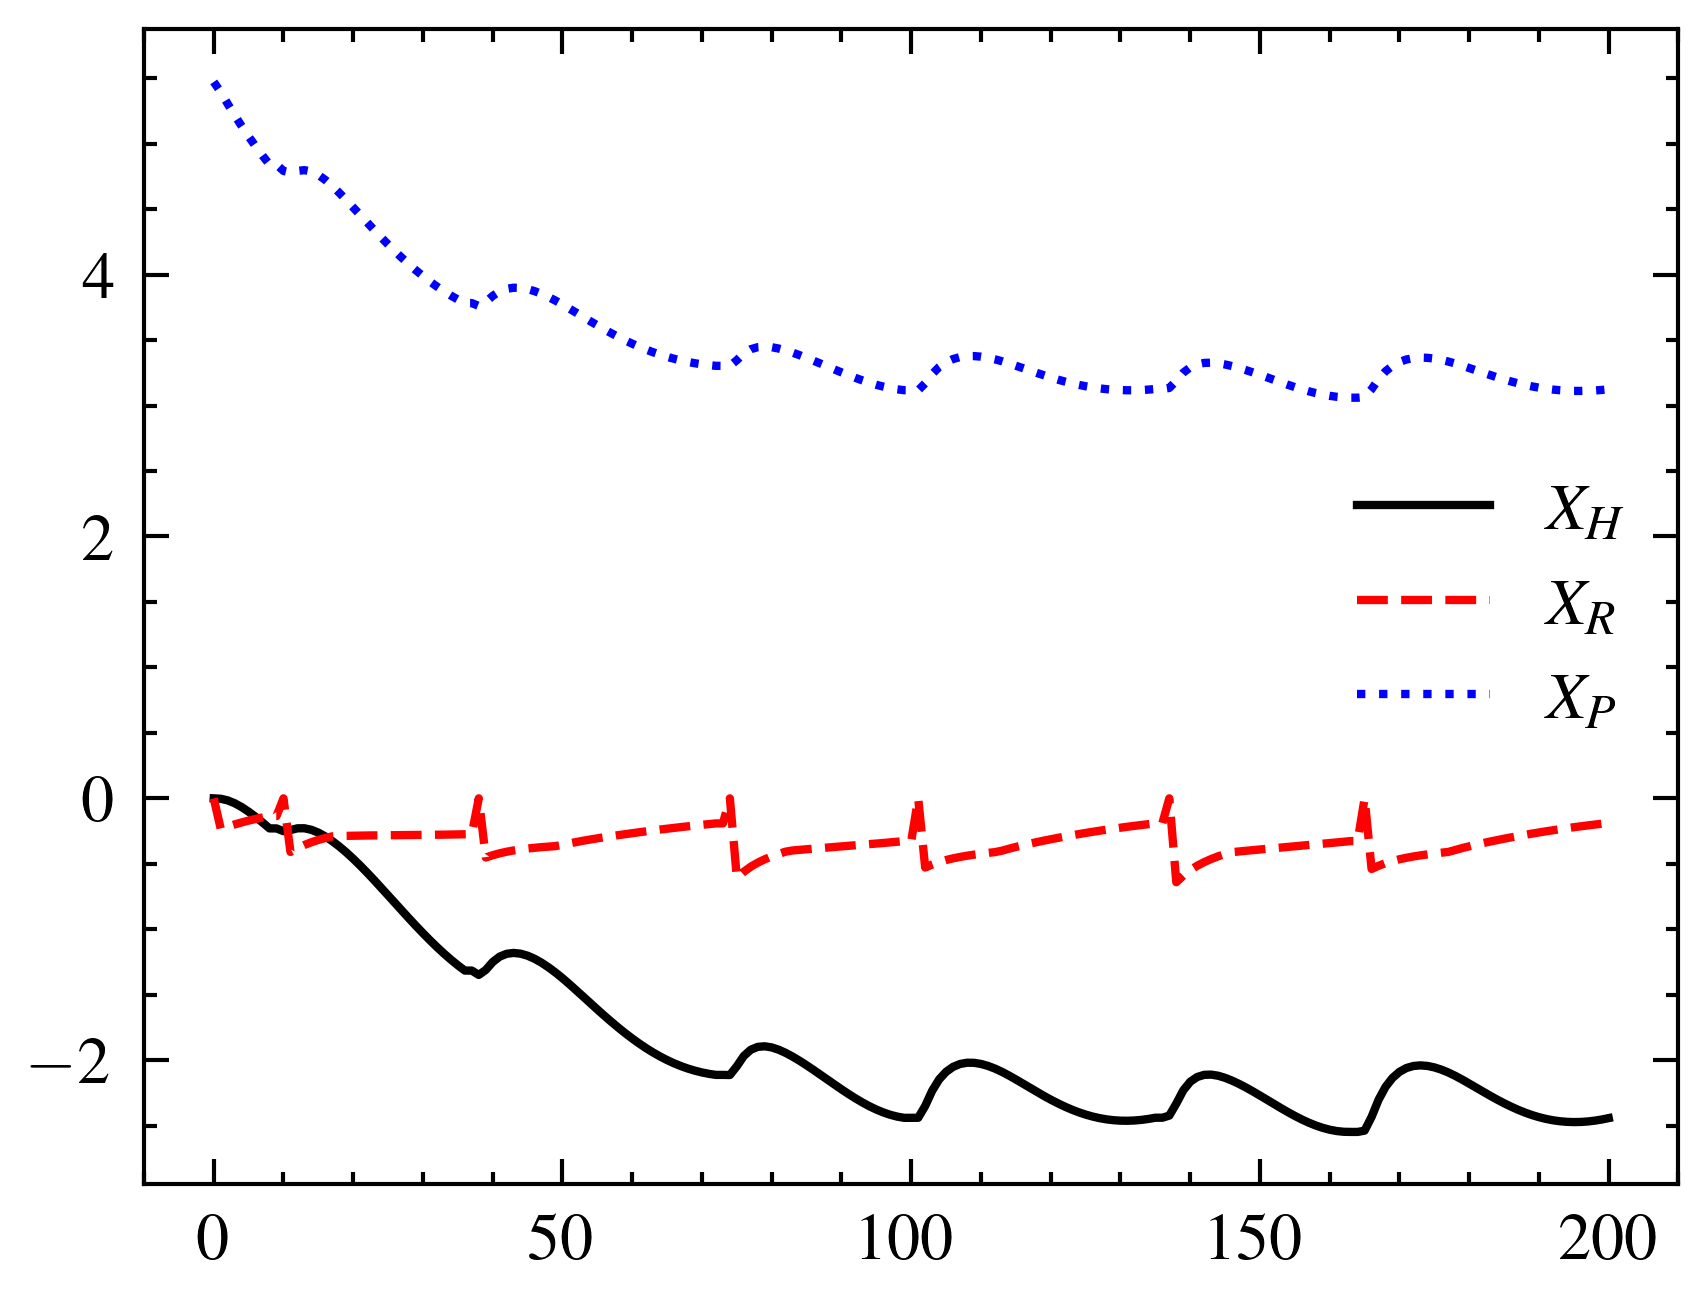

In [40]:
plt.plot(time_list,X_H_list, label=r"$X_H$")
plt.plot(time_list,X_R_list, label=r"$X_R$")
plt.plot(time_list,X_P_list, label=r"$X_P$")
plt.legend();

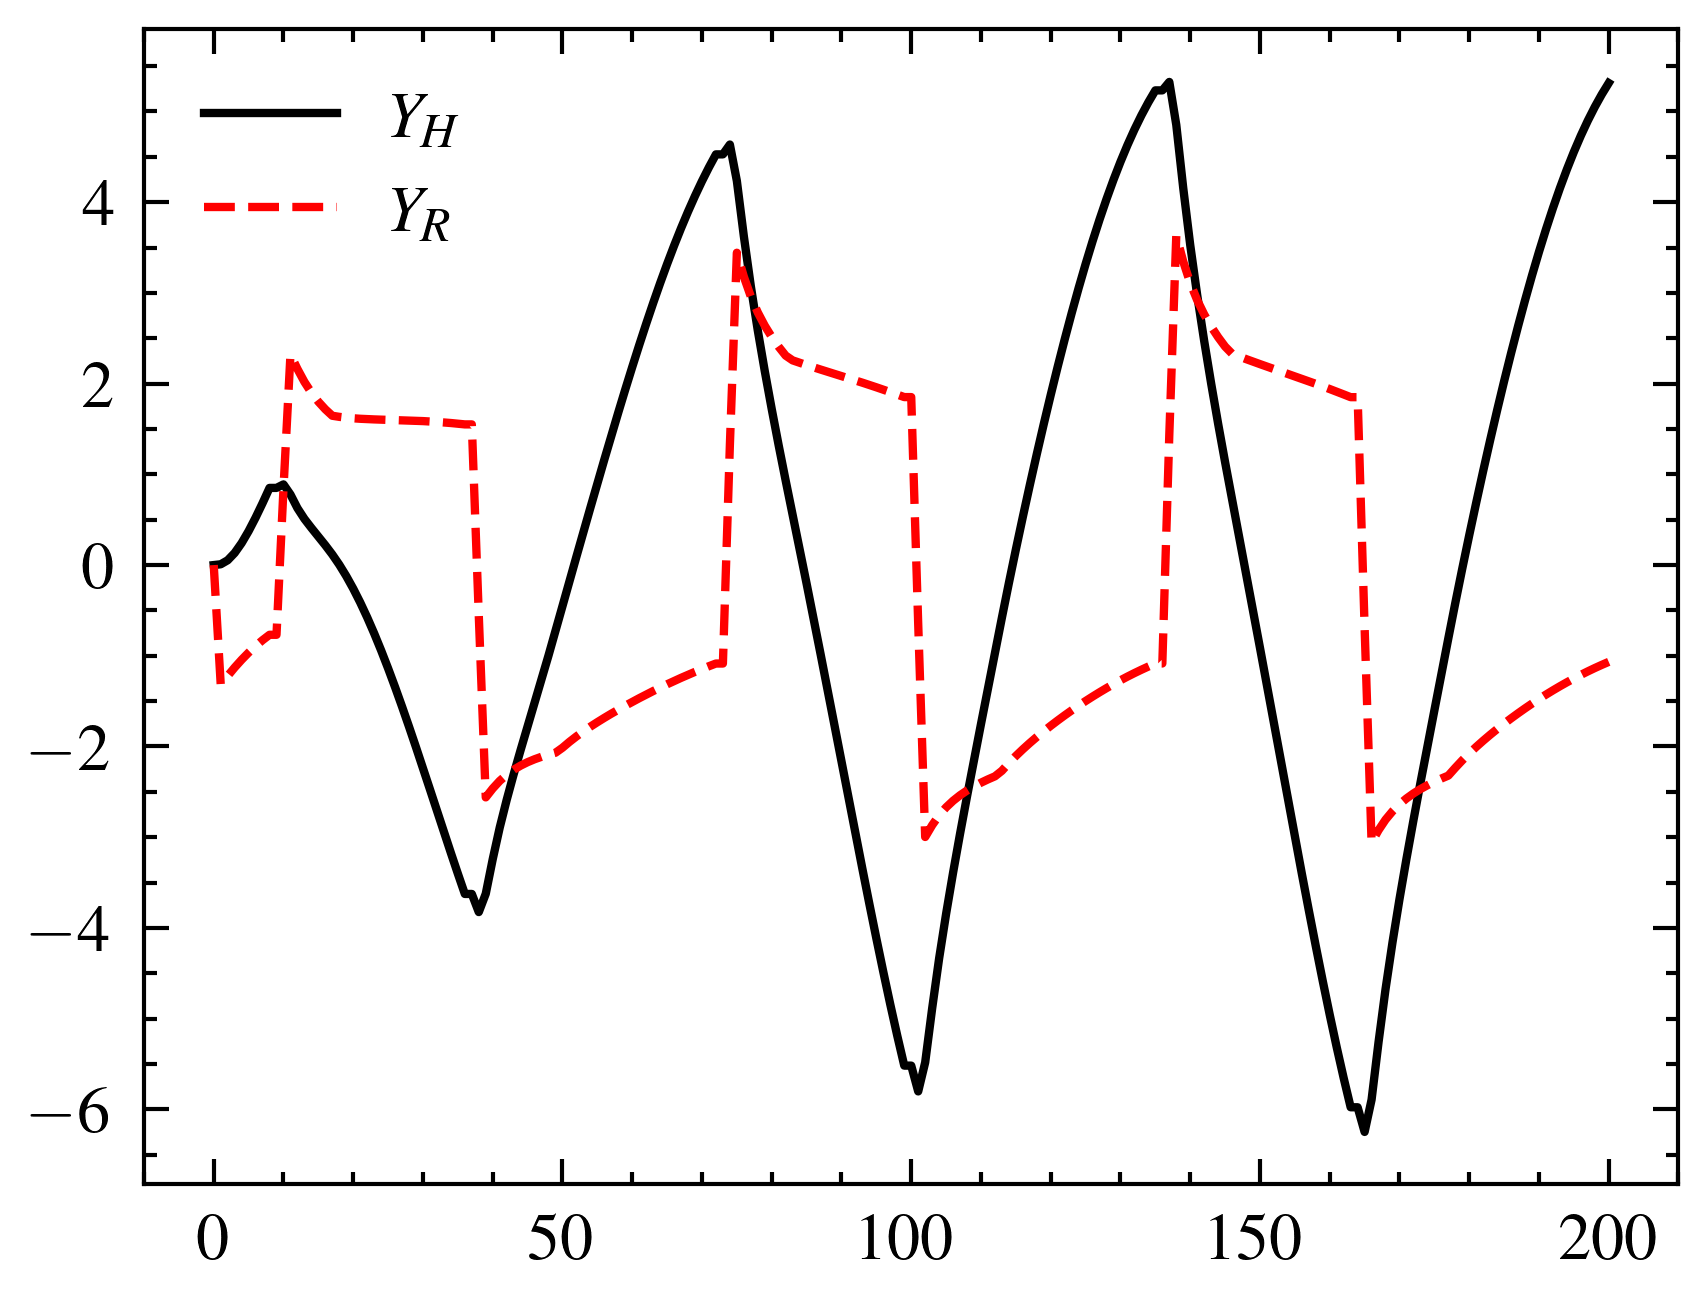

In [41]:
plt.plot(time_list,Y_H_list, label=r"$Y_H$")
plt.plot(time_list,Y_R_list, label=r"$Y_R$")
plt.legend();

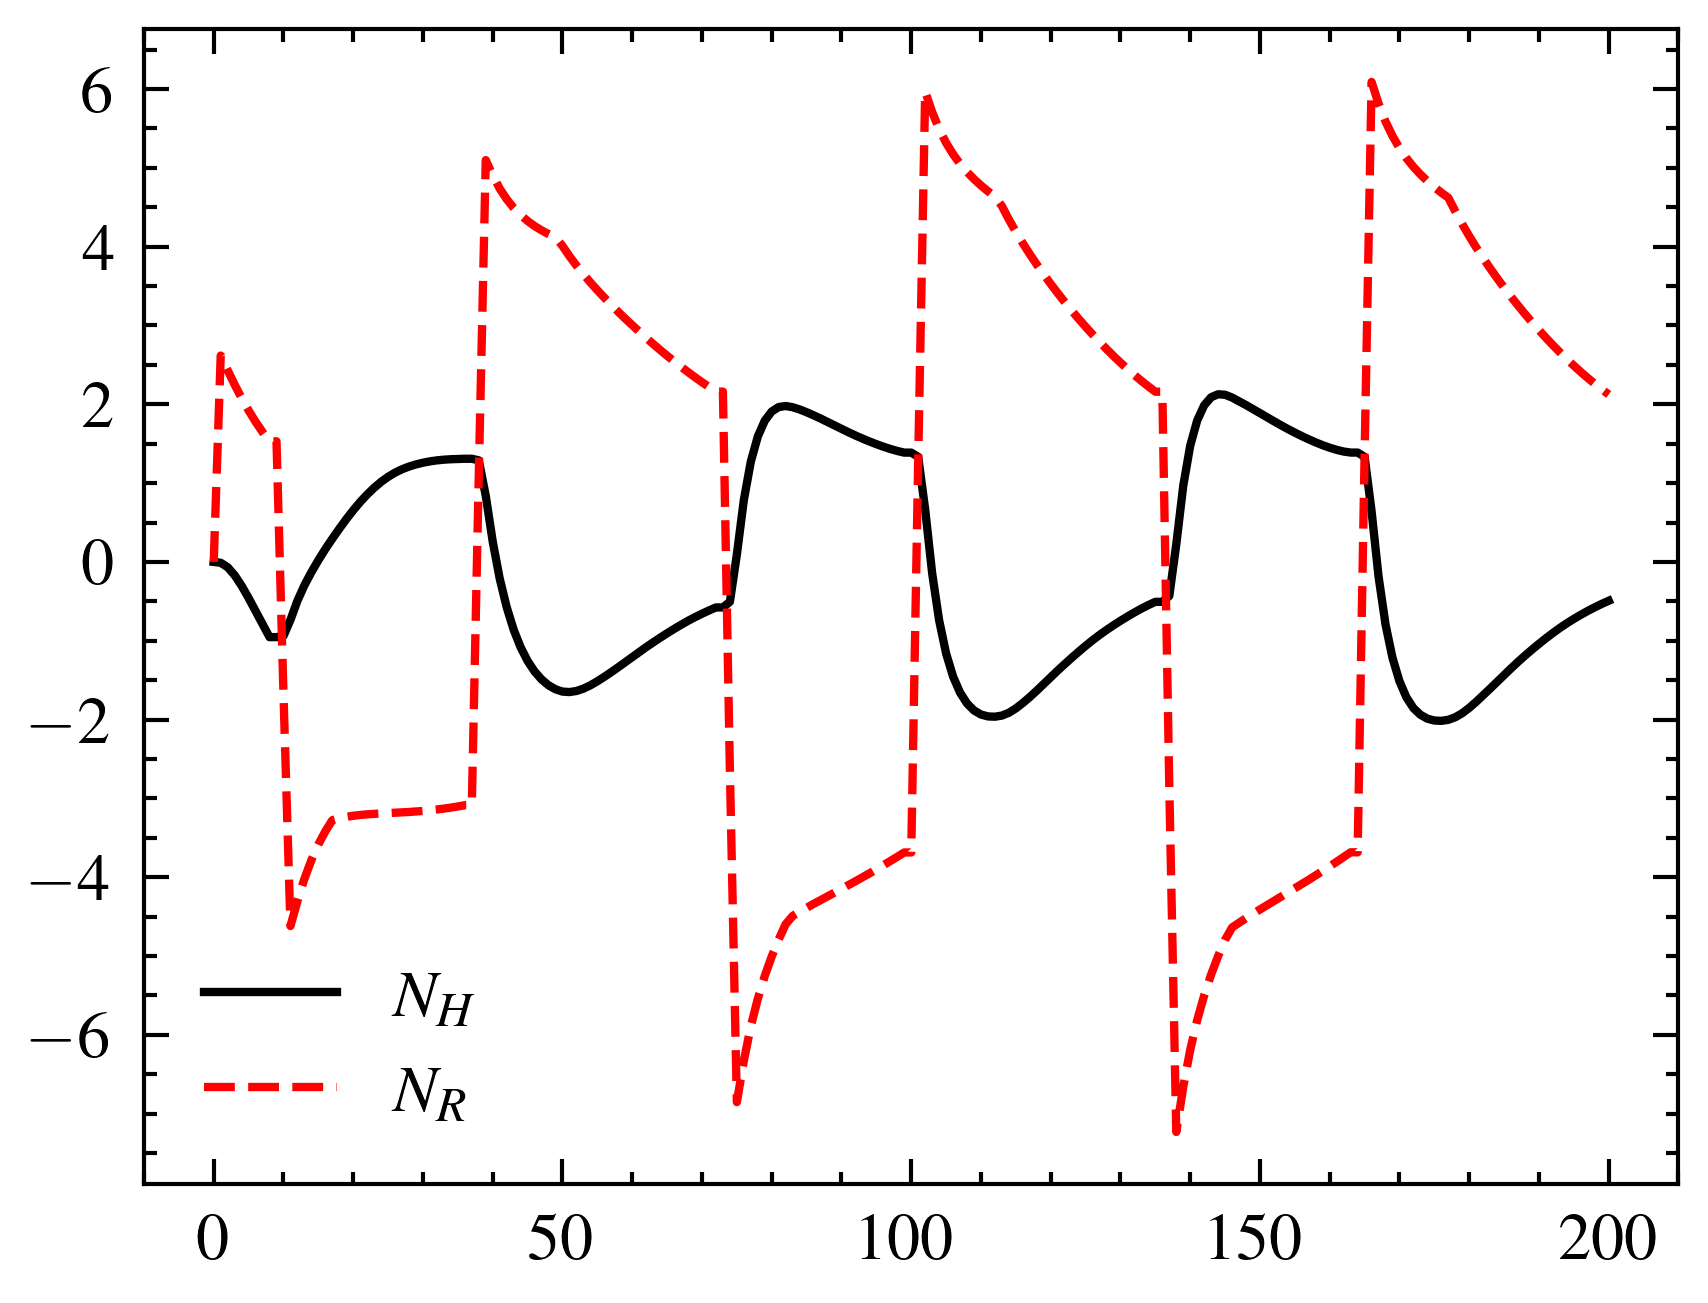

In [42]:
plt.plot(time_list,N_H_list, label=r"$N_H$")
plt.plot(time_list,N_R_list, label=r"$N_R$")
plt.legend();

In [43]:
def CreateData(result):
    df = pd.DataFrame({'time_list':time_list, 'u':u_list, 'v':v_list, 'r':r_list, 'x':x_list, 'y':y_list, 'psi':ship.psi, 'δ':ship.δ, 'npm':ship.npm, 'X_H_ref':X_H_list, 'X_R_ref':X_R_list, 'X_P_ref':X_P_list, 'Y_H_ref':Y_H_list, 'Y_R_ref':Y_R_list, 'N_H_ref':N_H_list, 'N_R_ref':N_R_list})
    df['x_bow'] = df['x'] + 0.5 * basic_params.L_pp * np.cos(df['psi'])
    df['y_bow'] = df['y'] + 0.5 * basic_params.L_pp * np.sin(df['psi'])
    df['x_stern'] = df['x'] - 0.5 * basic_params.L_pp * np.cos(df['psi'])
    df['y_stern'] = df['y'] - 0.5 * basic_params.L_pp * np.sin(df['psi'])
    return df

df = CreateData(result)
df.to_csv('observation/suzaku_z_obs.csv')

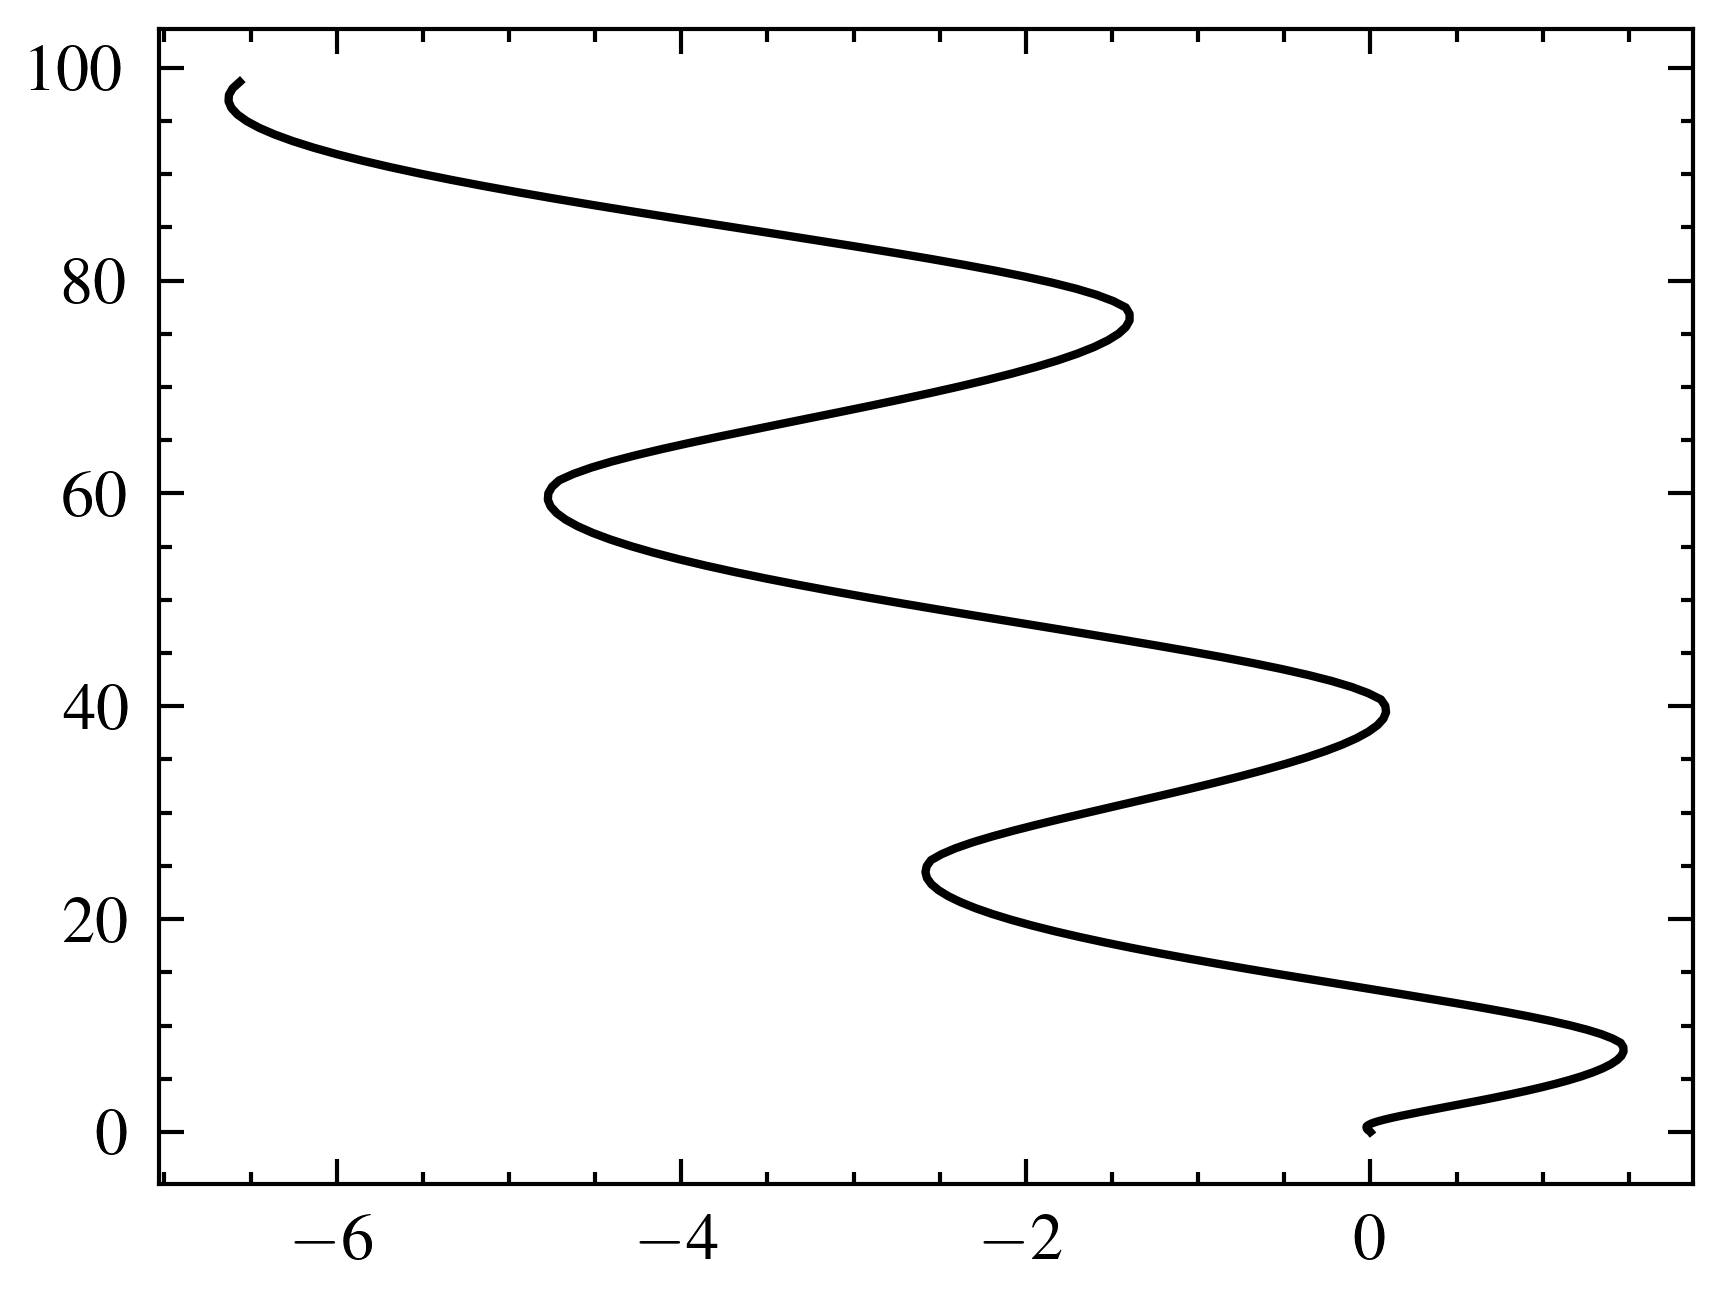

In [45]:
plt.plot(y_list, x_list)

(-3.0, 3.0)

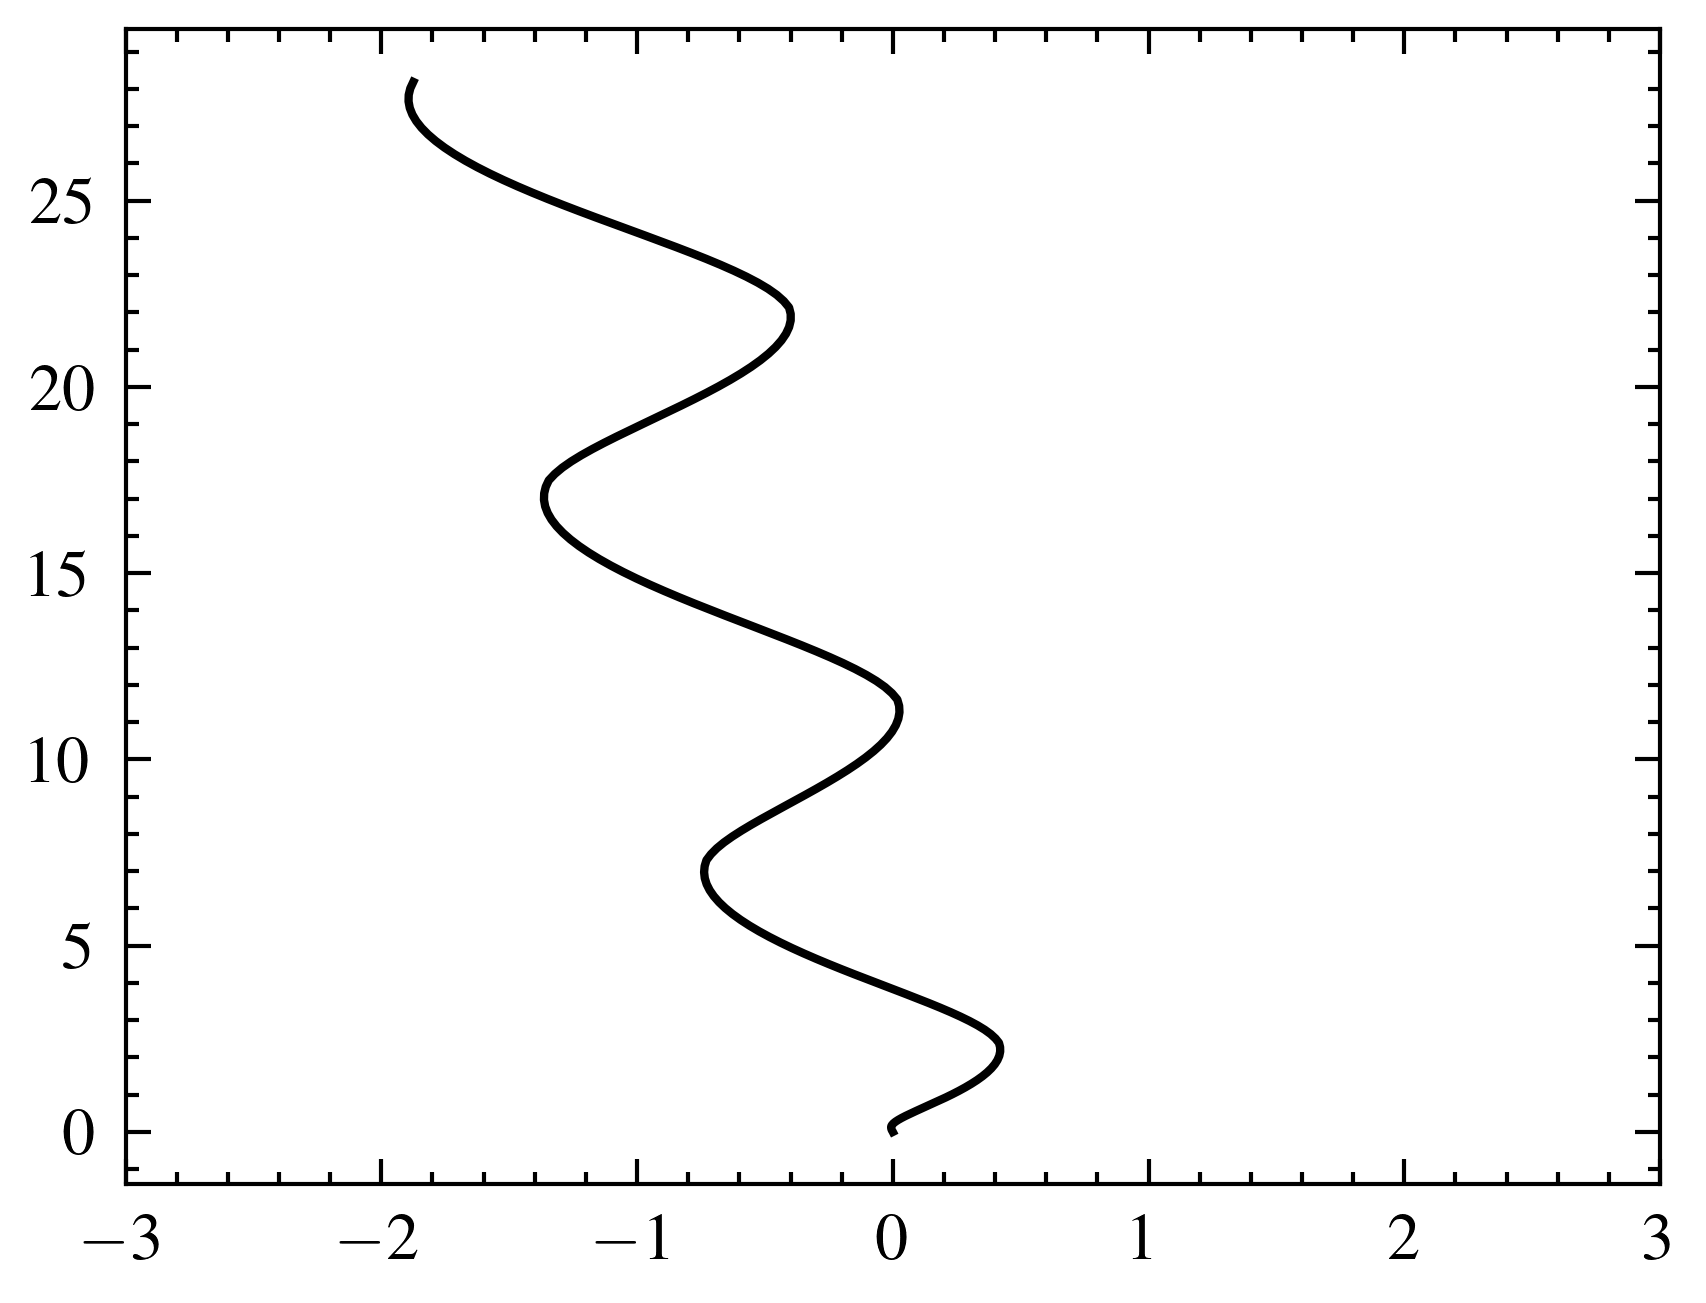

In [46]:
y_list = list(map(lambda y: y/L_pp, y_list))
x_list = list(map(lambda x: x/L_pp, x_list))
plt.plot(y_list, x_list)
plt.xlim(-3,3)

In [44]:
suzaku = pd.DataFrame({'time':time_list,
                        'u':u_list,
                        'v':v_list, 
                        'r':r_list, 
                        'x':x_list, 
                        'y':y_list, 
                        'psi':ψ_list,
                        # 'x1':ship_kt.x1,
                        # 'y1':ship_kt.y1,
                        # 'x2':ship_kt.x2,
                        # 'y2':ship_kt.y2,  
                        'X_F':ship_kt.X_F, #船体座標系
                        'Y_F':ship_kt.Y_F,
                        'N_F':ship_kt.N_F,
                        'u_ref':ship_kt.u_ref,
                        'v_ref':ship_kt.v_ref,
                        'r_ref':ship_kt.r_ref,
                        'x_ref':ship_kt.x_ref,
                        'y_ref':ship_kt.y_ref,
                        'psi_ref':ship_kt.psi_ref,
                        # 'x1_ref':ship_kt.x1_ref,
                        # 'y1_ref':ship_kt.y1_ref,
                        # 'x2_ref':ship_kt.x2_ref,
                        # 'y2_ref':ship_kt.y2_ref,
                        'X_F_ref':X_F, #設定値（船体座標）
                        'Y_F_ref':Y_F,
                        'N_F_ref':N_F,
                        'x_F_ref':X_F0, #設定値（固定座標）
                        'y_F_ref':Y_F0,
                        'n_F_ref':N_F,
                        # 'shipX_F':shipX_F, #軸補正後
                        # 'shipY_F':shipY_F,
                        # 'shipN_F':shipN_F,
                        'x_F':x_F, # 固定座標系
                        'y_F':y_F,
                        'n_F':ship_kt.N_F, 
                        # 'shipx_F':shipx_F, #軸補正後
                        # 'shipy_F':shipy_F,
                        # 'shipn_F':shipN_F,
                        'X_H':X_H_list,
                        'X_R':X_R_list,
                        'X_P':X_P_list,
                        'Y_H':Y_H_list,
                        'Y_R':Y_R_list,
                        'N_H':N_H_list,
                        'N_R':N_R_list,
                        'X_H_ref':X_H_ref_list,
                        'X_R_ref':X_R_ref_list,
                        'X_P_ref':X_P_ref_list,
                        'Y_H_ref':Y_H_ref_list,
                        'Y_R_ref':Y_R_ref_list,
                        'N_H_ref':N_H_ref_list,
                        'N_R_ref':N_R_ref_list,
})
# suzaku.to_csv('suzaku_data_0705/suzaku_0weight_5t_20deg_5hz_xyψ_-1.5YF_2.0v_9.csv')

NameError: name 'ship_kt' is not defined